In [ ]:
import re

# Define pipeline stages and latencies
pipeline_stages = {
    # integer
    'IADD': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1},
    'ISUB': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1},
    'IMUL': {'IF': 1, 'ID': 1, 'MUL': 12, 'WB': 1},
    'IDIV': {'IF': 1, 'ID': 1, 'DIV': 24, 'WB': 1},

    # floating
    'FADD': {'IF': 1, 'ID': 1, 'FADD': 18, 'WB': 1},
    'FSUB': {'IF': 1, 'ID': 1, 'FADD': 18, 'WB': 1},
    'FMUL': {'IF': 1, 'ID': 1, 'FMUL': 30, 'WB': 1},
    'FDIV': {'IF': 1, 'ID': 1, 'FDIV': 60, 'WB': 1},

    # logical operations
    'AND': {'IF': 1, 'ID': 1, 'AND': 1, 'WB': 1},
    'OR': {'IF': 1, 'ID': 1, 'OR': 1, 'WB': 1},
    'XOR': {'IF': 1, 'ID': 1, 'XOR': 1, 'WB': 1},
    'NOT': {'IF': 1, 'ID': 1, 'NOT': 1, 'WB': 1},

    # load and store
    'LD': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1},
    'ST': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1},

    # NOP
    'NOP': {'IF': 1},

    # move
    'MOV': {'IF': 1, 'ID': 1, 'MOV': 1, 'WB': 1}
}

def get_functional_unit_and_latency(stages):
    functional_units = ['ADD', 'MUL', 'DIV', 'FADD', 'FMUL', 'FDIV', 'MEM']
    for stage, latency in stages.items():
        if stage in functional_units:
            return stage, latency
    return None, None  # No functional unit found

def display_clock_cycle_execution(updated_instructions, total_cycles):
    # Initialize a timeline for each instruction
    timeline = {}
    for i, instr in enumerate(updated_instructions):
        timeline[i] = [' '] * total_cycles  # Initialize with empty spaces for all clock cycles

    # Track the start cycle for each instruction
    for i, instr in enumerate(updated_instructions):
        stages = instr['stages']
        current_cycle = i  # Start at cycle i (0-based index)
        for stage, latency in stages.items():
            # Fill the timeline for the current stage
            for cycle in range(current_cycle, current_cycle + latency):
                if cycle < total_cycles:  # Ensure we don't exceed the total_cycles limit
                    timeline[i][cycle] = stage
            current_cycle += latency

    # Determine maximum stage name length for uniform spacing
    max_stage_length = max(len(stage) for instr in updated_instructions for stage in instr['stages'])
    max_cycle_length = len(str(total_cycles))  # Maximum length of clock cycle numbers

    # Define column width based on the maximum length
    column_width = max(max_stage_length, max_cycle_length) + 2  # Add padding

    # Determine the maximum instruction name length for dynamic spacing
    max_instr_length = max(
        len(f"{i + 1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")
        if instr['op'] not in ['LD', 'ST', 'NOP']
        else len(f"{i + 1}: {instr['op']} {instr['dest']}, [{instr['src1']}]")
        if instr['op'] in ['LD', 'ST']
        else len(f"{i + 1}: NOP")
        for i, instr in enumerate(updated_instructions)
    )

    # Print the timeline
    print("Clock Cycle Execution:")
    print(" " * (max_instr_length + 2) + "|", end="")
    for cycle in range(1, total_cycles + 1):
        print(f" {cycle:^{column_width}} |", end="")  # Center-align clock cycles
    print()

    for i, instr in enumerate(updated_instructions):
        # Display the instruction name with index
        if instr['op'] in ['LD', 'ST']:
            instruction_name = f"{i + 1}: {instr['op']} {instr['dest']}, [{instr['src1']}]"
        elif instr['op'] == 'NOP':
            instruction_name = f"{i + 1}: NOP"
        else:
            instruction_name = f"{i + 1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}"

        # Print the instruction name and its stages
        print(f"{instruction_name: <{max_instr_length}} |", end="")
        for cycle in range(total_cycles):
            stage = timeline[i][cycle]
            print(f" {stage:^{column_width}} |", end="")  # Center-align stages
        print()

# Function to insert NOPs for structural hazards
def insert_nops_for_structural_hazards(instructions):
    updated_instructions = []
    total_cycles = 0
    prev_accum_latency = 0
    curr_latency = 0

    for i, instruction in enumerate(instructions):
        if i > 0:
            curr_instr = instructions[i]
            curr_func_unit, curr_func_latency = get_functional_unit_and_latency(curr_instr['stages'])

            # Iterate backward from i-1 to 0 to find the first conflicting instruction
            conflict_found = False
            for j in range(i - 1, -1, -1):
                prev_instr = instructions[j]
                prev_func_unit, prev_func_latency = get_functional_unit_and_latency(prev_instr['stages'])

                # Check for structural hazard (same functional unit)
                if prev_func_unit is not None and curr_func_unit == prev_func_unit:
                    conflict_found = True
                    # Update curr_latency based on the conflicting instruction's latency
                    if prev_func_latency is not None:
                        curr_latency = prev_func_latency - (i - j)
                    break  # Stop after finding the first conflict

            # If no conflict is found, reset curr_latency
            if not conflict_found or curr_latency < 0:
                curr_latency = 0

            # print("curr_func_unit, curr_func_latency", curr_func_unit, curr_func_latency)
            # print("prev_func_unit, prev_func_latency", prev_func_unit, prev_func_latency)
            # print("curr_latency : ", curr_latency)
            prev_accum_latency += curr_latency
            # print("prev_accum_latency : ", prev_accum_latency)

            # Insert NOPs for the accumulated latency
            for _ in range(curr_latency):
                updated_instructions.append({'op': 'NOP', 'stages': pipeline_stages['NOP']})

        # Add the current instruction
        updated_instructions.append(instruction)

        # Update total_cycles
        time = sum(instruction['stages'].values())
        total_cycles = max(i + time + prev_accum_latency, total_cycles)

    return updated_instructions, total_cycles

def handle_waw_and_war(updated_instructions, total_cycles):
    # Initialize a register counter to track availability
    register_counter = {f'R{i}': 0 for i in range(32)}  # R0 to R31

    # Function to find the next available register
    def find_available_register():
        for reg, counter in register_counter.items():
            if counter == 0:
                return reg
        return None  # No available register (should not happen in normal cases)

    # Iterate through instructions to handle WAW and WAR
    i = 0
    while i < len(updated_instructions):
        curr_instr = updated_instructions[i]

        # # Skip NOP instructions
        # if curr_instr['op'] == 'NOP':
        #     i += 1
        #     continue

        # Get the destination register of the current instruction
        if 'dest' in curr_instr and curr_instr['op'] != 'ST':
          dest_reg = curr_instr['dest']
        else:
          dest_reg = None

        # Handle WAW (Write-After-Write) hazard
        if dest_reg is not None:
            # Check if any previous instruction reads from the destination register
            for j in range(i - 1, -1, -1):
                prev_instr = updated_instructions[j]
                if ('dest' in prev_instr and prev_instr['dest'] == dest_reg and prev_instr['op'] != 'ST' and register_counter[dest_reg] != 0):
                    # Find a new available register
                    new_dest_reg = find_available_register()
                    print("prev_instr : ", prev_instr)
                    print(f"{dest_reg} : {register_counter[dest_reg]}")
                    if new_dest_reg is None:
                        print("Error: No available registers.")
                        return updated_instructions, total_cycles

                    # Update the destination register of the current instruction
                    print("curr_instr before : ", curr_instr)
                    curr_instr['dest'] = new_dest_reg
                    print("curr_instr after : ", curr_instr)
                    print("new_dest_reg : ", new_dest_reg)

                    # Update subsequent instructions that use the old destination register
                    for k in range(i + 1, len(updated_instructions)):
                        subsequent_instr = updated_instructions[k]
                        if 'src1' in subsequent_instr and subsequent_instr['src1'] == dest_reg:
                            subsequent_instr['src1'] = new_dest_reg
                            print("subsequent_instr : ", subsequent_instr)
                        if 'src2' in subsequent_instr and subsequent_instr['src2'] == dest_reg:
                            subsequent_instr['src2'] = new_dest_reg
                            print("subsequent_instr : ", subsequent_instr)
                        if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == dest_reg:
                            subsequent_instr['dest'] = new_dest_reg
                            print("subsequent_instr : ", subsequent_instr)

                    # Update the register counter for the new destination register
                    register_counter[new_dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages

        # # Handle WAR (Write-After-Read) hazard
        # if dest_reg is not None:
        #     # Check if any previous instruction reads from the destination register
        #     for j in range(i - 1, -1, -1):
        #         prev_instr = updated_instructions[j]
        #         if ('src1' in prev_instr and prev_instr['src1'] == dest_reg) or \
        #         ('src2' in prev_instr and prev_instr['src2'] == dest_reg) or \
        #         ('dest' in prev_instr and prev_instr['op'] == 'ST' and prev_instr['dest'] == dest_reg):
        #             # Find a new available register
        #             new_dest_reg = find_available_register()
        #             if new_dest_reg is None:
        #                 print("Error: No available registers.")
        #                 return updated_instructions, total_cycles

        #             # Update the destination register of the current instruction
        #             curr_instr['dest'] = new_dest_reg

        #             # Update subsequent instructions that use the old destination register
        #             for k in range(i + 1, len(updated_instructions)):
        #                 subsequent_instr = updated_instructions[k]
        #                 if 'src1' in subsequent_instr and subsequent_instr['src1'] == dest_reg:
        #                     subsequent_instr['src1'] = new_dest_reg
        #                 if 'src2' in subsequent_instr and subsequent_instr['src2'] == dest_reg:
        #                     subsequent_instr['src2'] = new_dest_reg
        #                 if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == dest_reg:
        #                     subsequent_instr['dest'] = new_dest_reg

        #             # Update the register counter for the new destination register
        #             register_counter[new_dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages
        #             break

        # # Update the register counter for the destination register
        # if dest_reg is not None:
        #     register_counter[dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages


        # if 'src1' in curr_instr and curr_instr['src1'] is not None and \
        # curr_instr['src1'] in {'R{i}': 0 for i in range(32)} and register_counter[curr_instr['src1']] == 0:
        #   register_counter[curr_instr['src1']] = sum(curr_instr['stages'].values()) - 2
        # if 'src2' in curr_instr and curr_instr['src2'] is not None and register_counter[curr_instr['src2']] == 0:
        #   register_counter[curr_instr['src2']] = sum(curr_instr['stages'].values()) - 2
        if 'dest' in curr_instr and curr_instr['dest'] is not None and \
         curr_instr['op'] != 'ST' and register_counter[curr_instr['dest']] == 0:
          register_counter[curr_instr['dest']] = sum(curr_instr['stages'].values()) - 2

        # Decrement the counter for all registers at each clock cycle
        for reg in register_counter:
            print(f"{reg} : {register_counter[reg]}")
            if register_counter[reg] > 0:
                register_counter[reg] -= 1

        i += 1

    return updated_instructions, total_cycles

# Function to insert NOPs for raw and waw dependencies
# The while loop dynamically adjusts to the changing size of updated_instructions.
# After inserting NOPs, the loop will not skip over the inserted NOPs and will continue to process all instructions (including the last one).
def handle_raw_dependencies(updated_instructions, total_cycles):
    i = 1  # Start from the second instruction
    while i < len(updated_instructions):  # Use a while loop to adjust dynamically
        curr_instr = updated_instructions[i]
        # print(f"{i} :  {curr_instr}")

        # print("len(updated_instructions) : ", len(updated_instructions))

        # Collect valid source registers (src1 and src2, if they exist)
        curr_registers = []
        if 'src1' in curr_instr and curr_instr['src1'] is not None:
            curr_registers.append(curr_instr['src1'])
        if 'src2' in curr_instr and curr_instr['src2'] is not None:
            curr_registers.append(curr_instr['src2'])
        if 'dest' in curr_instr and curr_instr['dest'] is not None and curr_instr['op'] == 'ST':
            curr_registers.append(curr_instr['dest'])

        max_time = 0
        max_time_index = -1

        # Iterate backward from i-1 to 0
        for j in range(i - 1, -1, -1):
            prev_instr = updated_instructions[j]

            # Check if the previous instruction has a destination register
            if 'dest' in prev_instr and prev_instr['dest'] is not None and prev_instr['op'] != 'ST':
                prev_dest_register = prev_instr['dest']  # Destination register of the previous instruction

                # Check if any source register of the current instruction matches the destination register of the previous instruction
                if prev_dest_register in curr_registers:
                    # Calculate the completion time of the previous instruction
                    prev_completion_time = j + sum(prev_instr['stages'].values())
                    if prev_completion_time > max_time:
                        max_time = prev_completion_time
                        max_time_index = j

        # If a dependency is found, calculate the number of NOPs needed
        if max_time_index != -1:
            # Calculate the number of NOPs
            nops_needed = (max_time_index + sum(updated_instructions[max_time_index]['stages'].values())) - (i + 2)  # 2 for IF and ID
            if nops_needed > 0:
                # Insert NOPs
                for _ in range(nops_needed):
                    updated_instructions.insert(i, {'op': 'NOP', 'stages': pipeline_stages['NOP']})

                # # Update total_cycles
                # total_cycles += nops_needed

                # After inserting NOPs, we do not increment i, as the newly inserted NOP will be processed next
                i += nops_needed
                continue  # Skip the normal increment and process the inserted NOP

        total_cycles = max(i + sum(updated_instructions[i]['stages'].values()), total_cycles)

        # Increment index to move to the next instruction
        i += 1

    return updated_instructions, total_cycles

# Function to parse assembly code
import re

def parse_assembly(assembly):
    instructions = []

    for line in assembly:
        line = line.strip()

        # Regex for arithmetic/logic instructions (e.g., IADD R1, R2, R3)
        match_arithmetic = re.match(r'^(IADD|ISUB|IMUL|IDIV|FADD|FSUB|FMUL|FDIV|AND|OR|XOR|NOT)\s+(R\d+),\s*(R\d+),\s*(R\d+)$', line)

        # Regex for MOV instructions (e.g., MOV R8, R7 or MOV R8, 1000)
        match_mov = re.match(r'^(MOV)\s+(R\d+),\s*(R\d+|\d+)$', line)

        # Regex for memory instructions with register or immediate address (e.g., LD R8, [R9] or LD R8, [1000])
        match_memory = re.match(r'^(LD|ST)\s+(R\d+),\s*\[(R\d+|\d+)\]$', line)

        # Regex for NOP instruction
        match_nop = re.match(r'^NOP$', line)

        if match_arithmetic:
            op = match_arithmetic.group(1)
            dest = match_arithmetic.group(2)
            src1 = match_arithmetic.group(3)
            src2 = match_arithmetic.group(4)
            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': src2, 'stages': pipeline_stages[op]})

        elif match_mov:
            op = match_mov.group(1)
            dest = match_mov.group(2)
            src1 = match_mov.group(3)
            # For MOV, src2 is None
            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': None, 'stages': pipeline_stages[op]})

        elif match_memory:
            op = match_memory.group(1)
            dest = match_memory.group(2)
            src1 = match_memory.group(3)
            # For LD/ST, src2 is None
            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': None, 'stages': pipeline_stages[op]})

        elif match_nop:
            instructions.append({'op': 'NOP', 'dest': None, 'src1': None, 'src2': None, 'stages': pipeline_stages['NOP']})

    return instructions

# Main function
def main():
    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FMUL R14, R15, R16"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16",
    #     "FADD R17, R18, R19"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "FDIV R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16",
    #     "FADD R17, R18, R19"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "IADD R7, R8, R9"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "IADD R7, R8, R9",
    #     "IADD R10, R11, R12"
    # ]

    # assembly_code = [
    #     "LD R7, [1000]",
    #     "IADD R1, R2, R3",
    #     "FMUL R4, R5, R6",
    #     "IADD R7, R8, R9",
    #     "IADD R10, R11, R12"
    # ]

    # assembly_code = [
    #     "LD R2, [1000]",
    #     "LD R3, [2000]",
    #     "IADD R1, R2, R3",
    #     "LD R2, [3000]",
    #     "IADD R4, R1, R2",
    #     "IADD R4, R4, R1",
    #     "IADD R4, R5, R6"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R1, R2"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R4, R2"
    # ]

    # assembly_code = [
    #     "IDIV R3, R1, R3",
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R4, R3"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IDIV R3, R1, R3",
    #     "ISUB R1, R4, R3"
    # ]

    # assembly_code = [
    #     "IDIV R3, R1, R3",
    #     "IMUL R1, R2, R4",
    #     "ISUB R6, R4, R5"
    # ]

    assembly_code = [
        "LD R2, [1000]",
        "LD R3, [2000]",
        "IADD R1, R2, R3",
        "LD R2, [3000]",
        "IADD R4, R1, R2",
        "IADD R4, R4, R1",
        "IADD R4, R5, R6",
        "ST R4, [3000]"
    ]

    # # calculator program
    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R3, R1, R2",
    #     "ISUB R4, R1, R2",
    #     "IMUL R5, R1, R2",
    #     "IDIV R6, R1, R2",
    #     "ST R3, [3000]",
    #     "ST R4, [4000]",
    #     "ST R5, [5000]",
    #     "ST R6, [6000]"
    # ]

    instructions = parse_assembly(assembly_code)
    updated_instructions, total_cycles = insert_nops_for_structural_hazards(instructions)
    updated_instructions, total_cycles = handle_raw_dependencies(updated_instructions, total_cycles)
    updated_instructions, total_cycles = handle_waw_and_war(updated_instructions, total_cycles)

    print("Updated Code with NOPs and Register Updates:")
    for instr in updated_instructions:
        if instr['op'] == 'NOP':
            print("NOP")
        else:
            if instr['op'] in ['LD', 'ST']:
                print(f"{instr['op']} {instr['dest']}, [{instr['src1']}]")
            else:
                print(f"{instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")

    print(f"\nTotal clock cycles: {total_cycles}")


    # for i, instr in enumerate(updated_instructions):
    #     if instr['op'] in ['LD', 'ST']:
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']} {instr['dest']}, [{instr['src1']}]")
    #     elif instr['op'] == 'NOP':
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']}")
    #     else:
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")
    display_clock_cycle_execution(updated_instructions, total_cycles)

if __name__ == "__main__":
    main()

R0 : 0
R1 : 0
R2 : 2
R3 : 0
R4 : 0
R5 : 0
R6 : 0
R7 : 0
R8 : 0
R9 : 0
R10 : 0
R11 : 0
R12 : 0
R13 : 0
R14 : 0
R15 : 0
R16 : 0
R17 : 0
R18 : 0
R19 : 0
R20 : 0
R21 : 0
R22 : 0
R23 : 0
R24 : 0
R25 : 0
R26 : 0
R27 : 0
R28 : 0
R29 : 0
R30 : 0
R31 : 0
R0 : 0
R1 : 0
R2 : 1
R3 : 2
R4 : 0
R5 : 0
R6 : 0
R7 : 0
R8 : 0
R9 : 0
R10 : 0
R11 : 0
R12 : 0
R13 : 0
R14 : 0
R15 : 0
R16 : 0
R17 : 0
R18 : 0
R19 : 0
R20 : 0
R21 : 0
R22 : 0
R23 : 0
R24 : 0
R25 : 0
R26 : 0
R27 : 0
R28 : 0
R29 : 0
R30 : 0
R31 : 0
R0 : 0
R1 : 0
R2 : 0
R3 : 1
R4 : 0
R5 : 0
R6 : 0
R7 : 0
R8 : 0
R9 : 0
R10 : 0
R11 : 0
R12 : 0
R13 : 0
R14 : 0
R15 : 0
R16 : 0
R17 : 0
R18 : 0
R19 : 0
R20 : 0
R21 : 0
R22 : 0
R23 : 0
R24 : 0
R25 : 0
R26 : 0
R27 : 0
R28 : 0
R29 : 0
R30 : 0
R31 : 0
R0 : 0
R1 : 7
R2 : 0
R3 : 0
R4 : 0
R5 : 0
R6 : 0
R7 : 0
R8 : 0
R9 : 0
R10 : 0
R11 : 0
R12 : 0
R13 : 0
R14 : 0
R15 : 0
R16 : 0
R17 : 0
R18 : 0
R19 : 0
R20 : 0
R21 : 0
R22 : 0
R23 : 0
R24 : 0
R25 : 0
R26 : 0
R27 : 0
R28 : 0
R29 : 0
R30 : 0
R31 : 0
R0 : 0
R1 : 6
R2

In [ ]:
import re

# Define pipeline stages and latencies
pipeline_stages = {
    # integer
    'IADD': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1},
    'ISUB': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1},
    'IMUL': {'IF': 1, 'ID': 1, 'MUL': 12, 'WB': 1},
    'IDIV': {'IF': 1, 'ID': 1, 'DIV': 24, 'WB': 1},

    # floating
    'FADD': {'IF': 1, 'ID': 1, 'FADD': 18, 'WB': 1},
    'FSUB': {'IF': 1, 'ID': 1, 'FADD': 18, 'WB': 1},
    'FMUL': {'IF': 1, 'ID': 1, 'FMUL': 30, 'WB': 1},
    'FDIV': {'IF': 1, 'ID': 1, 'FDIV': 60, 'WB': 1},

    # logical operations
    'AND': {'IF': 1, 'ID': 1, 'AND': 1, 'WB': 1},
    'OR': {'IF': 1, 'ID': 1, 'OR': 1, 'WB': 1},
    'XOR': {'IF': 1, 'ID': 1, 'XOR': 1, 'WB': 1},
    'NOT': {'IF': 1, 'ID': 1, 'NOT': 1, 'WB': 1},

    # load and store
    'LD': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1},
    'ST': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1},

    # NOP
    'NOP': {'IF': 1},

    # move
    'MOV': {'IF': 1, 'ID': 1, 'MOV': 1, 'WB': 1}
}

def get_functional_unit_and_latency(stages):
    functional_units = ['ADD', 'MUL', 'DIV', 'FADD', 'FMUL', 'FDIV', 'MEM']
    for stage, latency in stages.items():
        if stage in functional_units:
            return stage, latency
    return None, None  # No functional unit found

def display_clock_cycle_execution(updated_instructions, total_cycles):
    # Initialize a timeline for each instruction
    timeline = {}
    for i, instr in enumerate(updated_instructions):
        timeline[i] = [' '] * total_cycles  # Initialize with empty spaces for all clock cycles

    # Track the start cycle for each instruction
    for i, instr in enumerate(updated_instructions):
        stages = instr['stages']
        current_cycle = i  # Start at cycle i (0-based index)
        for stage, latency in stages.items():
            # Fill the timeline for the current stage
            for cycle in range(current_cycle, current_cycle + latency):
                if cycle < total_cycles:  # Ensure we don't exceed the total_cycles limit
                    timeline[i][cycle] = stage
            current_cycle += latency

    # Determine maximum stage name length for uniform spacing
    max_stage_length = max(len(stage) for instr in updated_instructions for stage in instr['stages'])
    max_cycle_length = len(str(total_cycles))  # Maximum length of clock cycle numbers

    # Define column width based on the maximum length
    column_width = max(max_stage_length, max_cycle_length) + 2  # Add padding

    # Determine the maximum instruction name length for dynamic spacing
    max_instr_length = max(
        len(f"{i + 1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")
        if instr['op'] not in ['LD', 'ST', 'NOP']
        else len(f"{i + 1}: {instr['op']} {instr['dest']}, [{instr['src1']}]")
        if instr['op'] in ['LD', 'ST']
        else len(f"{i + 1}: NOP")
        for i, instr in enumerate(updated_instructions)
    )

    # Print the timeline
    print("Clock Cycle Execution:")
    print(" " * (max_instr_length + 2) + "|", end="")
    for cycle in range(1, total_cycles + 1):
        print(f" {cycle:^{column_width}} |", end="")  # Center-align clock cycles
    print()

    for i, instr in enumerate(updated_instructions):
        # Display the instruction name with index
        if instr['op'] in ['LD', 'ST']:
            instruction_name = f"{i + 1}: {instr['op']} {instr['dest']}, [{instr['src1']}]"
        elif instr['op'] == 'NOP':
            instruction_name = f"{i + 1}: NOP"
        else:
            instruction_name = f"{i + 1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}"

        # Print the instruction name and its stages
        print(f"{instruction_name: <{max_instr_length}} |", end="")
        for cycle in range(total_cycles):
            stage = timeline[i][cycle]
            print(f" {stage:^{column_width}} |", end="")  # Center-align stages
        print()

# Function to insert NOPs for structural hazards
def insert_nops_for_structural_hazards(instructions):
    updated_instructions = []
    total_cycles = 0
    prev_accum_latency = 0
    curr_latency = 0

    for i, instruction in enumerate(instructions):
        if i > 0:
            curr_instr = instructions[i]
            curr_func_unit, curr_func_latency = get_functional_unit_and_latency(curr_instr['stages'])

            # Iterate backward from i-1 to 0 to find the first conflicting instruction
            conflict_found = False
            for j in range(i - 1, -1, -1):
                prev_instr = instructions[j]
                prev_func_unit, prev_func_latency = get_functional_unit_and_latency(prev_instr['stages'])

                # Check for structural hazard (same functional unit)
                if prev_func_unit is not None and curr_func_unit == prev_func_unit:
                    conflict_found = True
                    # Update curr_latency based on the conflicting instruction's latency
                    if prev_func_latency is not None:
                        curr_latency = prev_func_latency - (i - j)
                    break  # Stop after finding the first conflict

            # If no conflict is found, reset curr_latency
            if not conflict_found or curr_latency < 0:
                curr_latency = 0

            # print("curr_func_unit, curr_func_latency", curr_func_unit, curr_func_latency)
            # print("prev_func_unit, prev_func_latency", prev_func_unit, prev_func_latency)
            # print("curr_latency : ", curr_latency)
            prev_accum_latency += curr_latency
            # print("prev_accum_latency : ", prev_accum_latency)

            # Insert NOPs for the accumulated latency
            for _ in range(curr_latency):
                updated_instructions.append({'op': 'NOP', 'stages': pipeline_stages['NOP']})

        # Add the current instruction
        updated_instructions.append(instruction)

        # Update total_cycles
        time = sum(instruction['stages'].values())
        total_cycles = max(i + time + prev_accum_latency, total_cycles)

    return updated_instructions, total_cycles

def handle_waw_and_war(updated_instructions, total_cycles):
    # Initialize a register counter to track availability
    # register_counter = {f'R{i}': 0 for i in range(32)}  # R0 to R31
    register_counter = {f'R{i}': 0 for i in range(2)}  # R0 to R1

    # Function to find the next available register
    def find_available_register():
        for reg, counter in register_counter.items():
            if counter == 0:
                return reg
        return None  # No available register (should not happen in normal cases)

    # Iterate through instructions to handle WAW and WAR
    i = 0
    while i < len(updated_instructions):
        curr_instr = updated_instructions[i]

        # # Skip NOP instructions
        # if curr_instr['op'] == 'NOP':
        #     i += 1
        #     continue

        # Get the destination register of the current instruction
        if 'dest' in curr_instr and curr_instr['op'] != 'ST':
          dest_reg = curr_instr['dest']
        else:
          dest_reg = None

        # Handle WAW (Write-After-Write) hazard
        if dest_reg is not None:
            new_dest_reg = None

            # Check if any previous instruction reads from the destination register
            for j in range(i - 1, -1, -1):
                prev_instr = updated_instructions[j]
                if ('dest' in prev_instr and prev_instr['dest'] == dest_reg and prev_instr['op'] != 'ST' and register_counter[dest_reg] != 0):
                    # Find a new available register
                    new_dest_reg = find_available_register()
                    print("prev_instr : ", prev_instr)
                    print(f"{dest_reg} : {register_counter[dest_reg]}")
                    if new_dest_reg is None:
                        print("Error: No available registers.")
                        return updated_instructions, total_cycles

                    # Update the destination register of the current instruction
                    print("curr_instr before : ", curr_instr)
                    curr_instr['dest'] = new_dest_reg
                    print("curr_instr after : ", curr_instr)
                    print("new_dest_reg : ", new_dest_reg)

                    if new_dest_reg is not None:
                        break

            if new_dest_reg is not None:
                # Update subsequent instructions that use the old destination register
                for k in range(i + 1, len(updated_instructions)):
                    subsequent_instr = updated_instructions[k]
                    if 'src1' in subsequent_instr and subsequent_instr['src1'] == dest_reg:
                        subsequent_instr['src1'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'src2' in subsequent_instr and subsequent_instr['src2'] == dest_reg:
                        subsequent_instr['src2'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == dest_reg:
                        subsequent_instr['dest'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'dest' in subsequent_instr and subsequent_instr['op'] != 'ST' and subsequent_instr['dest'] == dest_reg:
                        break


            # Update the register counter for the new destination register
            if new_dest_reg is not None:
              register_counter[new_dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages

        # # Handle WAR (Write-After-Read) hazard
        # if dest_reg is not None:
        #     # Check if any previous instruction reads from the destination register
        #     for j in range(i - 1, -1, -1):
        #         prev_instr = updated_instructions[j]
        #         if ('src1' in prev_instr and prev_instr['src1'] == dest_reg) or \
        #         ('src2' in prev_instr and prev_instr['src2'] == dest_reg) or \
        #         ('dest' in prev_instr and prev_instr['op'] == 'ST' and prev_instr['dest'] == dest_reg):
        #             # Find a new available register
        #             new_dest_reg = find_available_register()
        #             if new_dest_reg is None:
        #                 print("Error: No available registers.")
        #                 return updated_instructions, total_cycles

        #             # Update the destination register of the current instruction
        #             curr_instr['dest'] = new_dest_reg

        #             # Update subsequent instructions that use the old destination register
        #             for k in range(i + 1, len(updated_instructions)):
        #                 subsequent_instr = updated_instructions[k]
        #                 if 'src1' in subsequent_instr and subsequent_instr['src1'] == dest_reg:
        #                     subsequent_instr['src1'] = new_dest_reg
        #                 if 'src2' in subsequent_instr and subsequent_instr['src2'] == dest_reg:
        #                     subsequent_instr['src2'] = new_dest_reg
        #                 if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == dest_reg:
        #                     subsequent_instr['dest'] = new_dest_reg

        #             # Update the register counter for the new destination register
        #             register_counter[new_dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages
        #             break

        # # Update the register counter for the destination register
        # if dest_reg is not None:
        #     register_counter[dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages


        # if 'src1' in curr_instr and curr_instr['src1'] is not None and \
        # curr_instr['src1'] in {'R{i}': 0 for i in range(32)} and register_counter[curr_instr['src1']] == 0:
        #   register_counter[curr_instr['src1']] = sum(curr_instr['stages'].values()) - 2
        # if 'src2' in curr_instr and curr_instr['src2'] is not None and register_counter[curr_instr['src2']] == 0:
        #   register_counter[curr_instr['src2']] = sum(curr_instr['stages'].values()) - 2
        if 'dest' in curr_instr and curr_instr['dest'] is not None and \
         curr_instr['op'] != 'ST' and register_counter[curr_instr['dest']] == 0:
          register_counter[curr_instr['dest']] = sum(curr_instr['stages'].values()) - 2

        # Decrement the counter for all registers at each clock cycle
        for reg in register_counter:
            print(f"{reg} : {register_counter[reg]}")
            if register_counter[reg] > 0:
                register_counter[reg] -= 1

        i += 1

    return updated_instructions, total_cycles

# Function to insert NOPs for raw and waw dependencies
# The while loop dynamically adjusts to the changing size of updated_instructions.
# After inserting NOPs, the loop will not skip over the inserted NOPs and will continue to process all instructions (including the last one).
def handle_raw_dependencies(updated_instructions, total_cycles):
    i = 1  # Start from the second instruction
    while i < len(updated_instructions):  # Use a while loop to adjust dynamically
        curr_instr = updated_instructions[i]
        # print(f"{i} :  {curr_instr}")

        # print("len(updated_instructions) : ", len(updated_instructions))

        # Collect valid source registers (src1 and src2, if they exist)
        curr_registers = []
        if 'src1' in curr_instr and curr_instr['src1'] is not None:
            curr_registers.append(curr_instr['src1'])
        if 'src2' in curr_instr and curr_instr['src2'] is not None:
            curr_registers.append(curr_instr['src2'])
        if 'dest' in curr_instr and curr_instr['dest'] is not None and curr_instr['op'] == 'ST':
            curr_registers.append(curr_instr['dest'])

        max_time = 0
        max_time_index = -1

        # Iterate backward from i-1 to 0
        for j in range(i - 1, -1, -1):
            prev_instr = updated_instructions[j]

            # Check if the previous instruction has a destination register
            if 'dest' in prev_instr and prev_instr['dest'] is not None and prev_instr['op'] != 'ST':
                prev_dest_register = prev_instr['dest']  # Destination register of the previous instruction

                # Check if any source register of the current instruction matches the destination register of the previous instruction
                if prev_dest_register in curr_registers:
                    # Calculate the completion time of the previous instruction
                    prev_completion_time = j + sum(prev_instr['stages'].values())
                    if prev_completion_time > max_time:
                        max_time = prev_completion_time
                        max_time_index = j

        # If a dependency is found, calculate the number of NOPs needed
        if max_time_index != -1:
            # Calculate the number of NOPs
            nops_needed = (max_time_index + sum(updated_instructions[max_time_index]['stages'].values())) - (i + 2)  # 2 for IF and ID
            if nops_needed > 0:
                # Insert NOPs
                for _ in range(nops_needed):
                    updated_instructions.insert(i, {'op': 'NOP', 'stages': pipeline_stages['NOP']})

                # # Update total_cycles
                # total_cycles += nops_needed

                # After inserting NOPs, we do not increment i, as the newly inserted NOP will be processed next
                i += nops_needed
                continue  # Skip the normal increment and process the inserted NOP

        total_cycles = max(i + sum(updated_instructions[i]['stages'].values()), total_cycles)

        # Increment index to move to the next instruction
        i += 1

    return updated_instructions, total_cycles

# Function to parse assembly code
import re

def parse_assembly(assembly):
    instructions = []
    valid_ops = ['IADD', 'ISUB', 'IMUL', 'IDIV', 'FADD', 'FSUB', 'FMUL', 'FDIV', 'AND', 'OR', 'XOR', 'NOT', 'LD', 'ST', 'MOV', 'NOP']

    for line in assembly:
        line = line.strip()

        # Skip empty lines
        if not line:
            continue

        # Regex for arithmetic/logic instructions (e.g., IADD R1, R2, R3)
        match_arithmetic = re.match(r'^(IADD|ISUB|IMUL|IDIV|FADD|FSUB|FMUL|FDIV|AND|OR|XOR|NOT)\s+(R\d+),\s*(R\d+),\s*(R\d+)$', line)

        # Regex for MOV instructions (e.g., MOV R8, R7 or MOV R8, 1000)
        match_mov = re.match(r'^(MOV)\s+(R\d+),\s*(R\d+|\d+)$', line)

        # Regex for memory instructions with register or immediate address (e.g., LD R8, [R9] or LD R8, [1000])
        match_memory = re.match(r'^(LD|ST)\s+(R\d+),\s*\[(R\d+|\d+)\]$', line)

        # Regex for NOP instruction
        match_nop = re.match(r'^NOP$', line)

        # Check if the operation is valid
        op = line.split()[0] if line else None
        if op not in valid_ops:
            print(f"Error: Unknown instruction `{op}`.")
            return []

        if match_arithmetic:
            op = match_arithmetic.group(1)
            dest = match_arithmetic.group(2)
            src1 = match_arithmetic.group(3)
            src2 = match_arithmetic.group(4)

            # Check if registers are valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 1):
                print(f"Error: Invalid register name `{dest}`.")
                return []
            if not (0 <= int(src1[1:]) <= 1):
                print(f"Error: Invalid register name `{src1}`.")
                return []
            if not (0 <= int(src2[1:]) <= 1):
                print(f"Error: Invalid register name `{src2}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': src2, 'stages': pipeline_stages[op]})

        elif match_mov:
            op = match_mov.group(1)
            dest = match_mov.group(2)
            src1 = match_mov.group(3)

            # Check if destination register is valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []

            # Check if source is a register and valid (R0 to R31)
            if src1.startswith('R') and not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': None, 'stages': pipeline_stages[op]})

        elif match_memory:
            op = match_memory.group(1)
            dest = match_memory.group(2)
            src1 = match_memory.group(3)

            # Check if destination register is valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []

            # Check if source is a register and valid (R0 to R31)
            if src1.startswith('R') and not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': None, 'stages': pipeline_stages[op]})

        elif match_nop:
            instructions.append({'op': 'NOP', 'dest': None, 'src1': None, 'src2': None, 'stages': pipeline_stages['NOP']})

        else:
            # If the line doesn't match any regex, it's an unknown instruction
            print(f"Error: Unknown instruction `{line.split()[0]}`.")
            return []

    return instructions

# Main function
def main():
    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FMUL R14, R15, R16"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16",
    #     "FADD R17, R18, R19"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "FDIV R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16",
    #     "FADD R17, R18, R19"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "IADD R7, R8, R9"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "IADD R7, R8, R9",
    #     "IADD R10, R11, R12"
    # ]

    # assembly_code = [
    #     "LD R7, [1000]",
    #     "IADD R1, R2, R3",
    #     "FMUL R4, R5, R6",
    #     "IADD R7, R8, R9",
    #     "IADD R10, R11, R12"
    # ]

    # assembly_code = [
    #     "LD R2, [1000]",
    #     "LD R3, [2000]",
    #     "IADD R1, R2, R3",
    #     "LD R2, [3000]",
    #     "IADD R4, R1, R2",
    #     "IADD R4, R4, R1",
    #     "IADD R4, R5, R6"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R1, R2"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R4, R2"
    # ]

    # assembly_code = [
    #     "IDIV R3, R1, R3",
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R4, R3"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IDIV R3, R1, R3",
    #     "ISUB R1, R4, R3"
    # ]

    # assembly_code = [
    #     "IDIV R3, R1, R3",
    #     "IMUL R1, R2, R4",
    #     "ISUB R6, R4, R5"
    # ]

    # assembly_code = [
    #     "LD R2, [1000]",
    #     "LD R3, [2000]",
    #     "IADD R1, R2, R3",
    #     "LD R2, [3000]",
    #     "IADD R4, R1, R2",
    #     "IADD R4, R4, R1",
    #     "IADD R4, R5, R6",
    #     "ST R4, [3000]",
    #     "ST R4, [4000]",
    #     "IADD R4, R5, R7",
    #     "ST R4, [5000]"
    # ]

    assembly_code = [
        "LD R0, [1000]",
        "LD R1, [2000]",
        "IADD R1, R1, R0",
        "IMUL R1, R0, R0",
        "IADD R1, R0, R0"
    ]

    # # calculator program
    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R3, R1, R2",
    #     "ISUB R4, R1, R2",
    #     "IMUL R5, R1, R2",
    #     "IDIV R6, R1, R2",
    #     "ST R3, [3000]",
    #     "ST R4, [4000]",
    #     "ST R5, [5000]",
    #     "ST R6, [6000]"
    # ]

    instructions = parse_assembly(assembly_code)
    if not instructions:
        return
    # updated_instructions, total_cycles = insert_nops_for_structural_hazards(instructions)
    # updated_instructions, total_cycles = handle_raw_dependencies(updated_instructions, total_cycles)
    # updated_instructions, total_cycles = handle_waw_and_war(updated_instructions, total_cycles)

    total_cycles = 0
    updated_instructions, total_cycles = handle_raw_dependencies(instructions, total_cycles)
    updated_instructions, total_cycles = insert_nops_for_structural_hazards(updated_instructions)
    updated_instructions, total_cycles = handle_waw_and_war(updated_instructions, total_cycles)

    print("Updated Code with NOPs and Register Updates:")
    for instr in updated_instructions:
        if instr['op'] == 'NOP':
            print("NOP")
        else:
            if instr['op'] in ['LD', 'ST']:
                print(f"{instr['op']} {instr['dest']}, [{instr['src1']}]")
            else:
                print(f"{instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")

    print(f"\nTotal clock cycles: {total_cycles}")


    # for i, instr in enumerate(updated_instructions):
    #     if instr['op'] in ['LD', 'ST']:
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']} {instr['dest']}, [{instr['src1']}]")
    #     elif instr['op'] == 'NOP':
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']}")
    #     else:
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")
    display_clock_cycle_execution(updated_instructions, total_cycles)

if __name__ == "__main__":
    main()

R0 : 2
R1 : 0
R0 : 1
R1 : 2
R0 : 0
R1 : 1
R0 : 0
R1 : 7
prev_instr :  {'op': 'IADD', 'dest': 'R1', 'src1': 'R1', 'src2': 'R0', 'stages': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1}}
R1 : 6
curr_instr before :  {'op': 'IMUL', 'dest': 'R1', 'src1': 'R0', 'src2': 'R0', 'stages': {'IF': 1, 'ID': 1, 'MUL': 12, 'WB': 1}}
curr_instr after :  {'op': 'IMUL', 'dest': 'R0', 'src1': 'R0', 'src2': 'R0', 'stages': {'IF': 1, 'ID': 1, 'MUL': 12, 'WB': 1}}
new_dest_reg :  R0
R0 : 13
R1 : 6
R0 : 12
R1 : 5
R0 : 11
R1 : 4
R0 : 10
R1 : 3
R0 : 9
R1 : 2
prev_instr :  {'op': 'IADD', 'dest': 'R1', 'src1': 'R1', 'src2': 'R0', 'stages': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1}}
R1 : 1
Error: No available registers.
Updated Code with NOPs and Register Updates:
LD R0, [1000]
LD R1, [2000]
NOP
IADD R1, R1, R0
IMUL R0, R0, R0
NOP
NOP
NOP
NOP
IADD R1, R0, R0

Total clock cycles: 19
Clock Cycle Execution:
                     |   1   |   2   |   3   |   4   |   5   |   6   |   7   |   8   |   9   |  10   |  11   |  12   |  13 

In [ ]:
import re

# Define pipeline stages and latencies
pipeline_stages = {
    # integer
    'IADD': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1},
    'ISUB': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1},
    'IMUL': {'IF': 1, 'ID': 1, 'MUL': 12, 'WB': 1},
    'IDIV': {'IF': 1, 'ID': 1, 'DIV': 24, 'WB': 1},

    # floating
    'FADD': {'IF': 1, 'ID': 1, 'FADD': 18, 'WB': 1},
    'FSUB': {'IF': 1, 'ID': 1, 'FADD': 18, 'WB': 1},
    'FMUL': {'IF': 1, 'ID': 1, 'FMUL': 30, 'WB': 1},
    'FDIV': {'IF': 1, 'ID': 1, 'FDIV': 60, 'WB': 1},

    # logical operations
    'AND': {'IF': 1, 'ID': 1, 'AND': 1, 'WB': 1},
    'OR': {'IF': 1, 'ID': 1, 'OR': 1, 'WB': 1},
    'XOR': {'IF': 1, 'ID': 1, 'XOR': 1, 'WB': 1},
    'NOT': {'IF': 1, 'ID': 1, 'NOT': 1, 'WB': 1},

    # load and store
    'LD': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1},
    'ST': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1},

    # NOP
    'NOP': {'IF': 1},

    # move
    'MOV': {'IF': 1, 'ID': 1, 'MOV': 1, 'WB': 1}
}

def get_functional_unit_and_latency(stages):
    functional_units = ['ADD', 'MUL', 'DIV', 'FADD', 'FMUL', 'FDIV', 'MEM']
    for stage, latency in stages.items():
        if stage in functional_units:
            return stage, latency
    return None, None  # No functional unit found

def display_clock_cycle_execution(updated_instructions, total_cycles):
    # Initialize a timeline for each instruction
    timeline = {}
    for i, instr in enumerate(updated_instructions):
        timeline[i] = [' '] * total_cycles  # Initialize with empty spaces for all clock cycles

    # Track the start cycle for each instruction
    for i, instr in enumerate(updated_instructions):
        stages = instr['stages']
        current_cycle = i  # Start at cycle i (0-based index)
        for stage, latency in stages.items():
            # Fill the timeline for the current stage
            for cycle in range(current_cycle, current_cycle + latency):
                if cycle < total_cycles:  # Ensure we don't exceed the total_cycles limit
                    timeline[i][cycle] = stage
            current_cycle += latency

    # Determine maximum stage name length for uniform spacing
    max_stage_length = max(len(stage) for instr in updated_instructions for stage in instr['stages'])
    max_cycle_length = len(str(total_cycles))  # Maximum length of clock cycle numbers

    # Define column width based on the maximum length
    column_width = max(max_stage_length, max_cycle_length) + 2  # Add padding

    # Determine the maximum instruction name length for dynamic spacing
    max_instr_length = max(
        len(f"{i + 1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")
        if instr['op'] not in ['LD', 'ST', 'NOP']
        else len(f"{i + 1}: {instr['op']} {instr['dest']}, [{instr['src1']}]")
        if instr['op'] in ['LD', 'ST']
        else len(f"{i + 1}: NOP")
        for i, instr in enumerate(updated_instructions)
    )

    # Print the timeline
    print("Clock Cycle Execution:")
    print(" " * (max_instr_length + 2) + "|", end="")
    for cycle in range(1, total_cycles + 1):
        print(f" {cycle:^{column_width}} |", end="")  # Center-align clock cycles
    print()

    for i, instr in enumerate(updated_instructions):
        # Display the instruction name with index
        if instr['op'] in ['LD', 'ST']:
            instruction_name = f"{i + 1}: {instr['op']} {instr['dest']}, [{instr['src1']}]"
        elif instr['op'] == 'NOP':
            instruction_name = f"{i + 1}: NOP"
        else:
            instruction_name = f"{i + 1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}"

        # Print the instruction name and its stages
        print(f"{instruction_name: <{max_instr_length}} |", end="")
        for cycle in range(total_cycles):
            stage = timeline[i][cycle]
            print(f" {stage:^{column_width}} |", end="")  # Center-align stages
        print()

def display_functional_units(updated_instructions, total_cycles):
    # Define the functional units
    functional_units = ['ADD', 'MUL', 'DIV', 'FADD', 'FMUL', 'FDIV', 'AND', 'OR', 'XOR', 'NOT', 'MEM']

    # Initialize a timeline for each functional unit
    timeline = {unit: [' '] * len(updated_instructions) for unit in functional_units}

    # Track the start cycle for each instruction
    for i, instr in enumerate(updated_instructions):
        stages = instr['stages']
        functional_unit, _ = get_functional_unit_and_latency(stages)
        # print("functional_unit : ", functional_unit)

        # Format the full instruction string
        if instr['op'] in ['LD', 'ST']:
            instruction_str = f"{instr['op']} {instr['dest']}, [{instr['src1']}]"
        elif instr['op'] == 'NOP':
            instruction_str = "NOP"
        else:
            instruction_str = f"{instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}"

        if functional_unit:
            # Place the instruction only in its corresponding functional unit
            timeline[functional_unit][i] = instruction_str
        else:
            # Handle NOP instructions (display in all functional units)
            for unit in functional_units:
                timeline[unit][i] = instruction_str

    # Determine the maximum instruction length for each functional unit
    max_instr_lengths = {unit: 0 for unit in functional_units}
    for unit in functional_units:
        for i in range(len(updated_instructions)):
            instruction = timeline[unit][i]
            if len(instruction) > max_instr_lengths[unit]:
                max_instr_lengths[unit] = len(instruction)

    # Adjust spacing based on the number of letters in the unit name
    for unit in functional_units:
        if len(unit) == 3:  # 3-letter units (DIV, AND, XOR, NOT, etc.)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], 10)  # More spacing
        elif len(unit) == 4:  # 4-letter units (FADD, FMUL, FDIV, etc.)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], 8)  # Less spacing
        else:  # Other units (e.g., MEM)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], len(unit))

    # Print the functional units horizontally at the top
    print("Functional Units Execution:")
    print(" " * len(str(len(updated_instructions))) + " |", end="")
    for unit in functional_units:
        print(f" {unit:^{max_instr_lengths[unit]}} |", end="")
    print()

    # Print the instruction number and the timeline
    for i in range(len(updated_instructions)):
        print(f"{i + 1:>{len(str(len(updated_instructions)))}} |", end="")
        for unit in functional_units:
            stage = timeline[unit][i]
            print(f" {stage:^{max_instr_lengths[unit]}} |", end="")
        print()

# Function to insert NOPs for structural hazards
def insert_nops_for_structural_hazards(instructions):
    updated_instructions = []
    total_cycles = 0
    prev_accum_latency = 0
    curr_latency = 0

    for i, instruction in enumerate(instructions):
        if i > 0:
            curr_instr = instructions[i]
            curr_func_unit, curr_func_latency = get_functional_unit_and_latency(curr_instr['stages'])

            # Iterate backward from i-1 to 0 to find the first conflicting instruction
            conflict_found = False
            for j in range(i - 1, -1, -1):
                prev_instr = instructions[j]
                prev_func_unit, prev_func_latency = get_functional_unit_and_latency(prev_instr['stages'])

                # Check for structural hazard (same functional unit)
                if prev_func_unit is not None and curr_func_unit == prev_func_unit:
                    conflict_found = True
                    # Update curr_latency based on the conflicting instruction's latency
                    if prev_func_latency is not None:
                        curr_latency = prev_func_latency - (i - j)
                    break  # Stop after finding the first conflict

            # If no conflict is found, reset curr_latency
            if not conflict_found or curr_latency < 0:
                curr_latency = 0

            # print("curr_func_unit, curr_func_latency", curr_func_unit, curr_func_latency)
            # print("prev_func_unit, prev_func_latency", prev_func_unit, prev_func_latency)
            # print("curr_latency : ", curr_latency)
            prev_accum_latency += curr_latency
            # print("prev_accum_latency : ", prev_accum_latency)

            # Insert NOPs for the accumulated latency
            for _ in range(curr_latency):
                updated_instructions.append({'op': 'NOP', 'stages': pipeline_stages['NOP']})

        # Add the current instruction
        updated_instructions.append(instruction)

        # Update total_cycles
        time = sum(instruction['stages'].values())
        total_cycles = max(i + time + prev_accum_latency, total_cycles)

    return updated_instructions, total_cycles

def handle_waw_and_war(updated_instructions, total_cycles):
    # Initialize a register counter to track availability
    register_counter = {f'R{i}': 0 for i in range(32)}  # R0 to R31
    # register_counter = {f'R{i}': 0 for i in range(2)}  # R0 to R1

    # Function to find the next available register
    def find_available_register():
        for reg, counter in register_counter.items():
            if counter == 0:
                return reg
        return None  # No available register (should not happen in normal cases)

    def find_available_register2(reg2):
        for reg, counter in register_counter.items():
            if counter == 0 and reg != reg2:
                return reg
        return None  # No available register (should not happen in normal cases)

    # Iterate through instructions to handle WAW and WAR
    i = 0
    while i < len(updated_instructions):
        curr_instr = updated_instructions[i]

        # # Skip NOP instructions
        # if curr_instr['op'] == 'NOP':
        #     i += 1
        #     continue

        # Get the destination register of the current instruction
        if 'dest' in curr_instr and curr_instr['op'] != 'ST':
          dest_reg = curr_instr['dest']
        else:
          dest_reg = None

        # Handle WAW (Write-After-Write) hazard
        if dest_reg is not None:
            new_dest_reg = None

            # Check if any previous instruction reads from the destination register
            for j in range(i - 1, -1, -1):
                prev_instr = updated_instructions[j]
                if ('dest' in prev_instr and prev_instr['dest'] == dest_reg and prev_instr['op'] != 'ST' and register_counter[dest_reg] != 0):
                    # Find a new available register
                    new_dest_reg = find_available_register()

                    k = i + 1
                    found = False
                    while k < len(updated_instructions):
                      subsequent_instr = updated_instructions[k]
                      if 'src1' in subsequent_instr and subsequent_instr['src1'] == new_dest_reg:
                          found = True
                          break
                      if 'src2' in subsequent_instr and subsequent_instr['src2'] == new_dest_reg:
                          found = True
                          break
                      if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == new_dest_reg:
                          found = True
                          break
                      k+=1

                    if found == True:
                      new_dest_reg = find_available_register2(new_dest_reg)

                    print("prev_instr : ", prev_instr)
                    print(f"{dest_reg} : {register_counter[dest_reg]}")
                    if new_dest_reg is None:
                        print("Error: No available registers.")
                        # return updated_instructions, total_cycles
                        return [], total_cycles

                        # # No available register, find the register with the smallest counter
                        # min_reg, min_counter = min(register_counter.items(), key=lambda x: x[1])  # Find register with smallest counter
                        # if min_reg is None:
                        #     print("Error: No registers available.")
                        #     return updated_instructions, total_cycles

                        # # Insert NOPs equal to the smallest counter value
                        # nops_needed = min_counter
                        # print("nops_needed : ", nops_needed)
                        # for _ in range(nops_needed):
                        #     updated_instructions.insert(i, {'op': 'NOP', 'stages': pipeline_stages['NOP']})
                        #     total_cycles += 1  # Increment total cycles

                        # # Reset the counter for the selected register
                        # register_counter[min_reg] = 0
                        # new_dest_reg = min_reg

                    # Update the destination register of the current instruction
                    print("curr_instr before : ", curr_instr)
                    curr_instr['dest'] = new_dest_reg
                    print("curr_instr after : ", curr_instr)
                    print("new_dest_reg : ", new_dest_reg)

                    if new_dest_reg is not None:
                        break

            if new_dest_reg is not None:
                k = i + 1
                # Update subsequent instructions that use the old destination register
                # for k in range(i + 1, len(updated_instructions)):
                while k < len(updated_instructions):
                    subsequent_instr = updated_instructions[k]
                    if 'src1' in subsequent_instr and subsequent_instr['src1'] == dest_reg:
                        subsequent_instr['src1'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'src2' in subsequent_instr and subsequent_instr['src2'] == dest_reg:
                        subsequent_instr['src2'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == dest_reg:
                        subsequent_instr['dest'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'dest' in subsequent_instr and subsequent_instr['op'] != 'ST' and subsequent_instr['dest'] == dest_reg:
                        break
                    k+=1


            # Update the register counter for the new destination register
            if new_dest_reg is not None:
              register_counter[new_dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages

        # # Handle WAR (Write-After-Read) hazard
        # if dest_reg is not None:
        #     # Check if any previous instruction reads from the destination register
        #     for j in range(i - 1, -1, -1):
        #         prev_instr = updated_instructions[j]
        #         if ('src1' in prev_instr and prev_instr['src1'] == dest_reg) or \
        #         ('src2' in prev_instr and prev_instr['src2'] == dest_reg) or \
        #         ('dest' in prev_instr and prev_instr['op'] == 'ST' and prev_instr['dest'] == dest_reg):
        #             # Find a new available register
        #             new_dest_reg = find_available_register()
        #             if new_dest_reg is None:
        #                 print("Error: No available registers.")
        #                 return updated_instructions, total_cycles

        #             # Update the destination register of the current instruction
        #             curr_instr['dest'] = new_dest_reg

        #             # Update subsequent instructions that use the old destination register
        #             for k in range(i + 1, len(updated_instructions)):
        #                 subsequent_instr = updated_instructions[k]
        #                 if 'src1' in subsequent_instr and subsequent_instr['src1'] == dest_reg:
        #                     subsequent_instr['src1'] = new_dest_reg
        #                 if 'src2' in subsequent_instr and subsequent_instr['src2'] == dest_reg:
        #                     subsequent_instr['src2'] = new_dest_reg
        #                 if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == dest_reg:
        #                     subsequent_instr['dest'] = new_dest_reg

        #             # Update the register counter for the new destination register
        #             register_counter[new_dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages
        #             break

        # # Update the register counter for the destination register
        # if dest_reg is not None:
        #     register_counter[dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages


        # if 'src1' in curr_instr and curr_instr['src1'] is not None and \
        # curr_instr['src1'] in {'R{i}': 0 for i in range(32)} and register_counter[curr_instr['src1']] == 0:
        #   register_counter[curr_instr['src1']] = sum(curr_instr['stages'].values()) - 2
        # if 'src2' in curr_instr and curr_instr['src2'] is not None and register_counter[curr_instr['src2']] == 0:
        #   register_counter[curr_instr['src2']] = sum(curr_instr['stages'].values()) - 2
        if 'dest' in curr_instr and curr_instr['dest'] is not None and \
         curr_instr['op'] != 'ST' and register_counter[curr_instr['dest']] == 0:
          register_counter[curr_instr['dest']] = sum(curr_instr['stages'].values()) - 2

        # Decrement the counter for all registers at each clock cycle
        for reg in register_counter:
            print(f"{reg} : {register_counter[reg]}")
            if register_counter[reg] > 0:
                register_counter[reg] -= 1

        i += 1

    return updated_instructions, total_cycles

# Function to insert NOPs for raw and waw dependencies
# The while loop dynamically adjusts to the changing size of updated_instructions.
# After inserting NOPs, the loop will not skip over the inserted NOPs and will continue to process all instructions (including the last one).
def handle_raw_dependencies(updated_instructions, total_cycles):
    i = 1  # Start from the second instruction
    while i < len(updated_instructions):  # Use a while loop to adjust dynamically
        curr_instr = updated_instructions[i]
        # print(f"{i} :  {curr_instr}")

        # print("len(updated_instructions) : ", len(updated_instructions))

        # Collect valid source registers (src1 and src2, if they exist)
        curr_registers = []
        if 'src1' in curr_instr and curr_instr['src1'] is not None:
            curr_registers.append(curr_instr['src1'])
        if 'src2' in curr_instr and curr_instr['src2'] is not None:
            curr_registers.append(curr_instr['src2'])
        if 'dest' in curr_instr and curr_instr['dest'] is not None and curr_instr['op'] == 'ST':
            curr_registers.append(curr_instr['dest'])

        max_time = 0
        max_time_index = -1

        # Iterate backward from i-1 to 0
        for j in range(i - 1, -1, -1):
            prev_instr = updated_instructions[j]

            # Check if the previous instruction has a destination register
            if 'dest' in prev_instr and prev_instr['dest'] is not None and prev_instr['op'] != 'ST':
                prev_dest_register = prev_instr['dest']  # Destination register of the previous instruction

                # Check if any source register of the current instruction matches the destination register of the previous instruction
                if prev_dest_register in curr_registers:
                    # Calculate the completion time of the previous instruction
                    prev_completion_time = j + sum(prev_instr['stages'].values())
                    if prev_completion_time > max_time:
                        max_time = prev_completion_time
                        max_time_index = j

        # If a dependency is found, calculate the number of NOPs needed
        if max_time_index != -1:
            # Calculate the number of NOPs
            nops_needed = (max_time_index + sum(updated_instructions[max_time_index]['stages'].values())) - (i + 2)  # 2 for IF and ID
            if nops_needed > 0:
                # Insert NOPs
                for _ in range(nops_needed):
                    updated_instructions.insert(i, {'op': 'NOP', 'stages': pipeline_stages['NOP']})

                # # Update total_cycles
                # total_cycles += nops_needed

                # After inserting NOPs, we do not increment i, as the newly inserted NOP will be processed next
                i += nops_needed
                continue  # Skip the normal increment and process the inserted NOP

        total_cycles = max(i + sum(updated_instructions[i]['stages'].values()), total_cycles)

        # Increment index to move to the next instruction
        i += 1

    return updated_instructions, total_cycles

# Function to parse assembly code
import re

def parse_assembly(assembly):
    instructions = []
    valid_ops = ['IADD', 'ISUB', 'IMUL', 'IDIV', 'FADD', 'FSUB', 'FMUL', 'FDIV', 'AND', 'OR', 'XOR', 'NOT', 'LD', 'ST', 'MOV', 'NOP']

    for line in assembly:
        line = line.strip()

        # Skip empty lines
        if not line:
            continue

        # Regex for arithmetic/logic instructions (e.g., IADD R1, R2, R3)
        match_arithmetic = re.match(r'^(IADD|ISUB|IMUL|IDIV|FADD|FSUB|FMUL|FDIV|AND|OR|XOR|NOT)\s+(R\d+),\s*(R\d+),\s*(R\d+)$', line)

        # Regex for MOV instructions (e.g., MOV R8, R7 or MOV R8, 1000)
        match_mov = re.match(r'^(MOV)\s+(R\d+),\s*(R\d+|\d+)$', line)

        # Regex for memory instructions with register or immediate address (e.g., LD R8, [R9] or LD R8, [1000])
        match_memory = re.match(r'^(LD|ST)\s+(R\d+),\s*\[(R\d+|\d+)\]$', line)

        # Regex for NOP instruction
        match_nop = re.match(r'^NOP$', line)

        # Check if the operation is valid
        op = line.split()[0] if line else None
        if op not in valid_ops:
            print(f"Error: Unknown instruction `{op}`.")
            return []

        if match_arithmetic:
            op = match_arithmetic.group(1)
            dest = match_arithmetic.group(2)
            src1 = match_arithmetic.group(3)
            src2 = match_arithmetic.group(4)

            # Check if registers are valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []
            if not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []
            if not (0 <= int(src2[1:]) <= 31):
                print(f"Error: Invalid register name `{src2}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': src2, 'stages': pipeline_stages[op]})

        elif match_mov:
            op = match_mov.group(1)
            dest = match_mov.group(2)
            src1 = match_mov.group(3)

            # Check if destination register is valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []

            # Check if source is a register and valid (R0 to R31)
            if src1.startswith('R') and not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': None, 'stages': pipeline_stages[op]})

        elif match_memory:
            op = match_memory.group(1)
            dest = match_memory.group(2)
            src1 = match_memory.group(3)

            # Check if destination register is valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []

            # Check if source is a register and valid (R0 to R31)
            if src1.startswith('R') and not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': None, 'stages': pipeline_stages[op]})

        elif match_nop:
            instructions.append({'op': 'NOP', 'dest': None, 'src1': None, 'src2': None, 'stages': pipeline_stages['NOP']})

        else:
            # If the line doesn't match any regex, it's an unknown instruction
            print(f"Error: Unknown instruction `{line.split()[0]}`.")
            return []

    return instructions

# Main function
def main():
    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FMUL R14, R15, R16"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16",
    #     "FADD R17, R18, R19"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "FDIV R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16",
    #     "FADD R17, R18, R19"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "IADD R7, R8, R9"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "IADD R7, R8, R9",
    #     "IADD R10, R11, R12"
    # ]

    # assembly_code = [
    #     "LD R7, [1000]",
    #     "IADD R1, R2, R3",
    #     "FMUL R4, R5, R6",
    #     "IADD R7, R8, R9",
    #     "IADD R10, R11, R12"
    # ]

    # assembly_code = [
    #     "LD R2, [1000]",
    #     "LD R3, [2000]",
    #     "IADD R1, R2, R3",
    #     "LD R2, [3000]",
    #     "IADD R4, R1, R2",
    #     "IADD R4, R4, R1",
    #     "IADD R4, R5, R6"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R1, R2"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R4, R2"
    # ]

    # assembly_code = [
    #     "IDIV R3, R1, R3",
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R4, R3"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IDIV R3, R1, R3",
    #     "ISUB R1, R4, R3"
    # ]

    # assembly_code = [
    #     "IDIV R3, R1, R3",
    #     "IMUL R1, R2, R4",
    #     "ISUB R6, R4, R5"
    # ]

    # assembly_code = [
    #     "LD R2, [1000]",
    #     "LD R3, [2000]",
    #     "IADD R1, R2, R3",
    #     "LD R2, [3000]",
    #     "IADD R4, R1, R2",
    #     "IADD R4, R4, R1",
    #     "IADD R4, R5, R6",
    #     "ST R4, [3000]",
    #     "ST R4, [4000]",
    #     "IADD R4, R5, R7",
    #     "ST R4, [5000]"
    # ]

    assembly_code = [
        "LD R0, [1000]",
        "LD R1, [2000]",
        "IADD R1, R1, R0",
        "IMUL R1, R0, R0",
        "IADD R1, R0, R0"
    ]

    # assembly_code = [
    #     "LD R0, [1000]",
    #     "LD R1, [2000]",
    #     "IADD R1, R1, R0",
    #     "IMUL R1, R0, R0",
    #     "IDIV R1, R0, R0"
    # ]

    # # calculator program
    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R3, R1, R2",
    #     "ST R3, [3000]",
    #     "ISUB R3, R1, R2",
    #     "ST R3, [4000]",
    #     "IMUL R3, R1, R2",
    #     "ST R3, [5000]",
    #     "IDIV R3, R1, R2",
    #     "ST R3, [6000]"
    # ]

    # # calculator program
    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R3, R1, R2",
    #     "ISUB R4, R1, R2",
    #     "IMUL R5, R1, R2",
    #     "IDIV R6, R1, R2",
    #     "ST R3, [3000]",
    #     "ST R4, [4000]",
    #     "ST R5, [5000]",
    #     "ST R6, [6000]"
    # ]

    instructions = parse_assembly(assembly_code)
    if not instructions:
        return
    # updated_instructions, total_cycles = insert_nops_for_structural_hazards(instructions)
    # updated_instructions, total_cycles = handle_raw_dependencies(updated_instructions, total_cycles)
    # updated_instructions, total_cycles = handle_waw_and_war(updated_instructions, total_cycles)

    total_cycles = 0
    updated_instructions, total_cycles = handle_raw_dependencies(instructions, total_cycles)
    updated_instructions, total_cycles = insert_nops_for_structural_hazards(updated_instructions)
    updated_instructions, total_cycles = handle_waw_and_war(updated_instructions, total_cycles)
    if not updated_instructions:
        print("Register Spill")
        return

    print("Updated Code with NOPs and Register Updates:")
    for instr in updated_instructions:
        if instr['op'] == 'NOP':
            print("NOP")
        else:
            if instr['op'] in ['LD', 'ST']:
                print(f"{instr['op']} {instr['dest']}, [{instr['src1']}]")
            else:
                print(f"{instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")

    print(f"\nTotal clock cycles: {total_cycles}")


    # for i, instr in enumerate(updated_instructions):
    #     if instr['op'] in ['LD', 'ST']:
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']} {instr['dest']}, [{instr['src1']}]")
    #     elif instr['op'] == 'NOP':
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']}")
    #     else:
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")
    print(" ")
    print(" ")
    display_functional_units(updated_instructions, total_cycles)
    print(" ")
    print(" ")
    display_clock_cycle_execution(updated_instructions, total_cycles)

if __name__ == "__main__":
    main()

R0 : 2
R1 : 0
R2 : 0
R3 : 0
R4 : 0
R5 : 0
R6 : 0
R7 : 0
R8 : 0
R9 : 0
R10 : 0
R11 : 0
R12 : 0
R13 : 0
R14 : 0
R15 : 0
R16 : 0
R17 : 0
R18 : 0
R19 : 0
R20 : 0
R21 : 0
R22 : 0
R23 : 0
R24 : 0
R25 : 0
R26 : 0
R27 : 0
R28 : 0
R29 : 0
R30 : 0
R31 : 0
R0 : 1
R1 : 2
R2 : 0
R3 : 0
R4 : 0
R5 : 0
R6 : 0
R7 : 0
R8 : 0
R9 : 0
R10 : 0
R11 : 0
R12 : 0
R13 : 0
R14 : 0
R15 : 0
R16 : 0
R17 : 0
R18 : 0
R19 : 0
R20 : 0
R21 : 0
R22 : 0
R23 : 0
R24 : 0
R25 : 0
R26 : 0
R27 : 0
R28 : 0
R29 : 0
R30 : 0
R31 : 0
R0 : 0
R1 : 1
R2 : 0
R3 : 0
R4 : 0
R5 : 0
R6 : 0
R7 : 0
R8 : 0
R9 : 0
R10 : 0
R11 : 0
R12 : 0
R13 : 0
R14 : 0
R15 : 0
R16 : 0
R17 : 0
R18 : 0
R19 : 0
R20 : 0
R21 : 0
R22 : 0
R23 : 0
R24 : 0
R25 : 0
R26 : 0
R27 : 0
R28 : 0
R29 : 0
R30 : 0
R31 : 0
R0 : 0
R1 : 7
R2 : 0
R3 : 0
R4 : 0
R5 : 0
R6 : 0
R7 : 0
R8 : 0
R9 : 0
R10 : 0
R11 : 0
R12 : 0
R13 : 0
R14 : 0
R15 : 0
R16 : 0
R17 : 0
R18 : 0
R19 : 0
R20 : 0
R21 : 0
R22 : 0
R23 : 0
R24 : 0
R25 : 0
R26 : 0
R27 : 0
R28 : 0
R29 : 0
R30 : 0
R31 : 0
prev_instr :  {'

In [ ]:
import re

# Define pipeline stages and latencies
pipeline_stages = {
    # integer
    'IADD': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1},
    'ISUB': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1},
    'IMUL': {'IF': 1, 'ID': 1, 'MUL': 12, 'WB': 1},
    'IDIV': {'IF': 1, 'ID': 1, 'DIV': 24, 'WB': 1},

    # floating
    'FADD': {'IF': 1, 'ID': 1, 'FADD': 18, 'WB': 1},
    'FSUB': {'IF': 1, 'ID': 1, 'FADD': 18, 'WB': 1},
    'FMUL': {'IF': 1, 'ID': 1, 'FMUL': 30, 'WB': 1},
    'FDIV': {'IF': 1, 'ID': 1, 'FDIV': 60, 'WB': 1},

    # logical operations
    'AND': {'IF': 1, 'ID': 1, 'AND': 1, 'WB': 1},
    'OR': {'IF': 1, 'ID': 1, 'OR': 1, 'WB': 1},
    'XOR': {'IF': 1, 'ID': 1, 'XOR': 1, 'WB': 1},
    'NOT': {'IF': 1, 'ID': 1, 'NOT': 1, 'WB': 1},

    # load and store
    'LD': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1},
    'ST': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1},

    # NOP
    'NOP': {'IF': 1},

    # move
    'MOV': {'IF': 1, 'ID': 1, 'MOV': 1, 'WB': 1}
}

def get_functional_unit_and_latency(stages):
    functional_units = ['ADD', 'MUL', 'DIV', 'FADD', 'FMUL', 'FDIV', 'MEM']
    for stage, latency in stages.items():
        if stage in functional_units:
            return stage, latency
    return None, None  # No functional unit found

def display_clock_cycle_execution(updated_instructions, total_cycles):
    # Initialize a timeline for each instruction
    timeline = {}
    for i, instr in enumerate(updated_instructions):
        timeline[i] = [' '] * total_cycles  # Initialize with empty spaces for all clock cycles

    # Track the start cycle for each instruction
    for i, instr in enumerate(updated_instructions):
        stages = instr['stages']
        current_cycle = i  # Start at cycle i (0-based index)

        # Always display IF and ID first
        timeline[i][current_cycle] = 'IF'
        current_cycle += 1
        timeline[i][current_cycle] = 'ID'
        current_cycle += 1

        # Add wait cycles (`_`) if any
        if 'wait_cycles' in instr:
            for cycle in range(current_cycle, current_cycle + instr['wait_cycles']):
                if cycle < total_cycles:
                    timeline[i][cycle] = '_'
            current_cycle += instr['wait_cycles']

        # Fill the timeline for the remaining stages
        for stage, latency in stages.items():
            if stage not in ['IF', 'ID']:  # Skip IF and ID since they are already handled
                for cycle in range(current_cycle, current_cycle + latency):
                    if cycle < total_cycles:
                        timeline[i][cycle] = stage
                current_cycle += latency

    # Determine maximum stage name length for uniform spacing
    max_stage_length = max(len(stage) for instr in updated_instructions for stage in instr['stages'])
    max_cycle_length = len(str(total_cycles))  # Maximum length of clock cycle numbers

    # Define column width based on the maximum length
    column_width = max(max_stage_length, max_cycle_length) + 2  # Add padding

    # Determine the maximum instruction name length for dynamic spacing
    max_instr_length = max(
        len(f"{i + 1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")
        if instr['op'] not in ['LD', 'ST', 'NOP']
        else len(f"{i + 1}: {instr['op']} {instr['dest']}, [{instr['src1']}]")
        if instr['op'] in ['LD', 'ST']
        else len(f"{i + 1}: NOP")
        for i, instr in enumerate(updated_instructions)
    )

    # Print the timeline
    print("Clock Cycle Execution:")
    print(" " * (max_instr_length + 2) + "|", end="")
    for cycle in range(1, total_cycles + 1):
        print(f" {cycle:^{column_width}} |", end="")  # Center-align clock cycles
    print()

    for i, instr in enumerate(updated_instructions):
        # Display the instruction name with index
        if instr['op'] in ['LD', 'ST']:
            instruction_name = f"{i + 1}: {instr['op']} {instr['dest']}, [{instr['src1']}]"
        elif instr['op'] == 'NOP':
            instruction_name = f"{i + 1}: NOP"
        else:
            instruction_name = f"{i + 1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}"

        # Print the instruction name and its stages
        print(f"{instruction_name: <{max_instr_length}} |", end="")
        for cycle in range(total_cycles):
            stage = timeline[i][cycle]
            print(f" {stage:^{column_width}} |", end="")  # Center-align stages
        print()

def display_functional_units(updated_instructions, total_cycles):
    # Define the functional units
    functional_units = ['ADD', 'MUL', 'DIV', 'FADD', 'FMUL', 'FDIV', 'AND', 'OR', 'XOR', 'NOT', 'MEM']

    # Initialize a timeline for each functional unit
    timeline = {unit: [' '] * len(updated_instructions) for unit in functional_units}

    # Track the start cycle for each instruction
    for i, instr in enumerate(updated_instructions):
        stages = instr['stages']
        functional_unit, _ = get_functional_unit_and_latency(stages)
        # print("functional_unit : ", functional_unit)

        # Format the full instruction string
        if instr['op'] in ['LD', 'ST']:
            instruction_str = f"{instr['op']} {instr['dest']}, [{instr['src1']}]"
        elif instr['op'] == 'NOP':
            instruction_str = "NOP"
        else:
            instruction_str = f"{instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}"

        if functional_unit:
            # Place the instruction only in its corresponding functional unit
            timeline[functional_unit][i] = instruction_str
        else:
            # Handle NOP instructions (display in all functional units)
            for unit in functional_units:
                timeline[unit][i] = instruction_str

    # Determine the maximum instruction length for each functional unit
    max_instr_lengths = {unit: 0 for unit in functional_units}
    for unit in functional_units:
        for i in range(len(updated_instructions)):
            instruction = timeline[unit][i]
            if len(instruction) > max_instr_lengths[unit]:
                max_instr_lengths[unit] = len(instruction)

    # Adjust spacing based on the number of letters in the unit name
    for unit in functional_units:
        if len(unit) == 3:  # 3-letter units (DIV, AND, XOR, NOT, etc.)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], 10)  # More spacing
        elif len(unit) == 4:  # 4-letter units (FADD, FMUL, FDIV, etc.)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], 8)  # Less spacing
        else:  # Other units (e.g., MEM)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], len(unit))

    # Print the functional units horizontally at the top
    print("Functional Units Execution:")
    print(" " * len(str(len(updated_instructions))) + " |", end="")
    for unit in functional_units:
        print(f" {unit:^{max_instr_lengths[unit]}} |", end="")
    print()

    # Print the instruction number and the timeline
    for i in range(len(updated_instructions)):
        print(f"{i + 1:>{len(str(len(updated_instructions)))}} |", end="")
        for unit in functional_units:
            stage = timeline[unit][i]
            print(f" {stage:^{max_instr_lengths[unit]}} |", end="")
        print()

# Function to handle structural and raw hazards
def handle_hazards(instructions):
    updated_instructions = []
    total_cycles = 0

    for i, instruction in enumerate(instructions):
        if i > 0:
            curr_instr = instructions[i]
            curr_func_unit, curr_func_latency = get_functional_unit_and_latency(curr_instr['stages'])

            # Track wait cycles for structural and RAW hazards
            structural_wait = 0

            # Check for structural hazards (same functional unit)
            for j in range(i - 1, -1, -1):
                prev_instr = instructions[j]
                prev_func_unit, prev_func_latency = get_functional_unit_and_latency(prev_instr['stages'])

                # Structural hazard: Same functional unit
                if prev_func_unit is not None and curr_func_unit == prev_func_unit:
                    # Calculate the number of wait cycles needed
                    structural_wait = max(structural_wait, (j - i + sum(prev_instr['stages'].values()) - 3)) + prev_instr.get('wait_cycles', 0)  # 3 for IF, ID and WB
                    # wait_cycles = max(wait_cycles, structural_wait)
                    break  # Stop after finding the first conflict

            # Check for RAW hazards (data dependencies)
            raw_wait = 0
            curr_registers = []
            if 'src1' in curr_instr and curr_instr['src1'] is not None:
                curr_registers.append(curr_instr['src1'])
            if 'src2' in curr_instr and curr_instr['src2'] is not None:
                curr_registers.append(curr_instr['src2'])
            if 'dest' in curr_instr and curr_instr['dest'] is not None and curr_instr['op'] == 'ST':
                curr_registers.append(curr_instr['dest'])

            for j in range(i - 1, -1, -1):
                prev_instr = instructions[j]
                # Check if the previous instruction writes to a register used by the current instruction
                if 'dest' in prev_instr and prev_instr['dest'] is not None and prev_instr['op'] != 'ST':
                    prev_dest_register = prev_instr['dest']
                    if prev_dest_register in curr_registers:
                        # Calculate the number of wait cycles needed
                        raw_wait = max(raw_wait, (j + sum(prev_instr['stages'].values())) - (i + 2)) + prev_instr.get('wait_cycles', 0)  # 2 for IF and ID
                        # wait_cycles = max(wait_cycles, raw_wait)
                        break

            # Add wait cycles to the current instruction
            # if wait_cycles > 0:
            #     if 'wait_cycles' not in curr_instr:
            #         curr_instr['wait_cycles'] = 0
            #     curr_instr['wait_cycles'] += wait_cycles
            if structural_wait >= raw_wait:
                # if 'wait_cycles' not in curr_instr:
                #     curr_instr['wait_cycles'] = 0
                curr_instr['wait_cycles'] = structural_wait
                print("structural_wait : ", structural_wait)
            else:
                # if 'wait_cycles' not in curr_instr:
                #     curr_instr['wait_cycles'] = 0
                curr_instr['wait_cycles'] = raw_wait
                print("raw_wait : ", raw_wait)

        # Add the current instruction
        # updated_instructions.append(instruction)
        print(f"instruction : {instruction}, curr_instr['wait_cycles'] : {instruction.get('wait_cycles', 0)}")

        # Update total_cycles
        time = sum(instruction['stages'].values())
        total_cycles = max(i + time + instruction.get('wait_cycles', 0), total_cycles)

    return instructions, total_cycles

def handle_waw_and_war(updated_instructions, total_cycles):
    # Initialize a register counter to track availability
    register_counter = {f'R{i}': 0 for i in range(32)}  # R0 to R31
    # register_counter = {f'R{i}': 0 for i in range(2)}  # R0 to R1

    # Function to find the next available register
    def find_available_register():
        for reg, counter in register_counter.items():
            if counter == 0:
                return reg
        return None  # No available register (should not happen in normal cases)

    def find_available_register2(reg2):
        for reg, counter in register_counter.items():
            if counter == 0 and reg != reg2:
                return reg
        return None  # No available register (should not happen in normal cases)

    # Iterate through instructions to handle WAW and WAR
    i = 0
    while i < len(updated_instructions):
        curr_instr = updated_instructions[i]

        # # Skip NOP instructions
        # if curr_instr['op'] == 'NOP':
        #     i += 1
        #     continue

        # Get the destination register of the current instruction
        if 'dest' in curr_instr and curr_instr['op'] != 'ST':
          dest_reg = curr_instr['dest']
        else:
          dest_reg = None

        # Handle WAW (Write-After-Write) hazard
        if dest_reg is not None:
            new_dest_reg = None

            # Check if any previous instruction reads from the destination register
            for j in range(i - 1, -1, -1):
                prev_instr = updated_instructions[j]
                if ('dest' in prev_instr and prev_instr['dest'] == dest_reg and prev_instr['op'] != 'ST' and register_counter[dest_reg] != 0):
                    # Find a new available register
                    new_dest_reg = find_available_register()

                    k = i + 1
                    found = False
                    while k < len(updated_instructions):
                      subsequent_instr = updated_instructions[k]
                      if 'src1' in subsequent_instr and subsequent_instr['src1'] == new_dest_reg:
                          found = True
                          break
                      if 'src2' in subsequent_instr and subsequent_instr['src2'] == new_dest_reg:
                          found = True
                          break
                      if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == new_dest_reg:
                          found = True
                          break
                      k+=1

                    if found == True:
                      new_dest_reg = find_available_register2(new_dest_reg)

                    print("prev_instr : ", prev_instr)
                    print(f"{dest_reg} : {register_counter[dest_reg]}")
                    if new_dest_reg is None:
                        print("Error: No available registers.")
                        # return updated_instructions, total_cycles
                        return [], total_cycles

                        # # No available register, find the register with the smallest counter
                        # min_reg, min_counter = min(register_counter.items(), key=lambda x: x[1])  # Find register with smallest counter
                        # if min_reg is None:
                        #     print("Error: No registers available.")
                        #     return updated_instructions, total_cycles

                        # # Insert NOPs equal to the smallest counter value
                        # nops_needed = min_counter
                        # print("nops_needed : ", nops_needed)
                        # for _ in range(nops_needed):
                        #     updated_instructions.insert(i, {'op': 'NOP', 'stages': pipeline_stages['NOP']})
                        #     total_cycles += 1  # Increment total cycles

                        # # Reset the counter for the selected register
                        # register_counter[min_reg] = 0
                        # new_dest_reg = min_reg

                    # Update the destination register of the current instruction
                    print("curr_instr before : ", curr_instr)
                    curr_instr['dest'] = new_dest_reg
                    print("curr_instr after : ", curr_instr)
                    print("new_dest_reg : ", new_dest_reg)

                    if new_dest_reg is not None:
                        break

            if new_dest_reg is not None:
                k = i + 1
                # Update subsequent instructions that use the old destination register
                # for k in range(i + 1, len(updated_instructions)):
                while k < len(updated_instructions):
                    subsequent_instr = updated_instructions[k]
                    if 'src1' in subsequent_instr and subsequent_instr['src1'] == dest_reg:
                        subsequent_instr['src1'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'src2' in subsequent_instr and subsequent_instr['src2'] == dest_reg:
                        subsequent_instr['src2'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == dest_reg:
                        subsequent_instr['dest'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'dest' in subsequent_instr and subsequent_instr['op'] != 'ST' and subsequent_instr['dest'] == dest_reg:
                        break
                    k+=1


            # Update the register counter for the new destination register
            if new_dest_reg is not None:
              register_counter[new_dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages

        # # Handle WAR (Write-After-Read) hazard
        # if dest_reg is not None:
        #     # Check if any previous instruction reads from the destination register
        #     for j in range(i - 1, -1, -1):
        #         prev_instr = updated_instructions[j]
        #         if ('src1' in prev_instr and prev_instr['src1'] == dest_reg) or \
        #         ('src2' in prev_instr and prev_instr['src2'] == dest_reg) or \
        #         ('dest' in prev_instr and prev_instr['op'] == 'ST' and prev_instr['dest'] == dest_reg):
        #             # Find a new available register
        #             new_dest_reg = find_available_register()
        #             if new_dest_reg is None:
        #                 print("Error: No available registers.")
        #                 return updated_instructions, total_cycles

        #             # Update the destination register of the current instruction
        #             curr_instr['dest'] = new_dest_reg

        #             # Update subsequent instructions that use the old destination register
        #             for k in range(i + 1, len(updated_instructions)):
        #                 subsequent_instr = updated_instructions[k]
        #                 if 'src1' in subsequent_instr and subsequent_instr['src1'] == dest_reg:
        #                     subsequent_instr['src1'] = new_dest_reg
        #                 if 'src2' in subsequent_instr and subsequent_instr['src2'] == dest_reg:
        #                     subsequent_instr['src2'] = new_dest_reg
        #                 if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == dest_reg:
        #                     subsequent_instr['dest'] = new_dest_reg

        #             # Update the register counter for the new destination register
        #             register_counter[new_dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages
        #             break

        # # Update the register counter for the destination register
        # if dest_reg is not None:
        #     register_counter[dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages


        # if 'src1' in curr_instr and curr_instr['src1'] is not None and \
        # curr_instr['src1'] in {'R{i}': 0 for i in range(32)} and register_counter[curr_instr['src1']] == 0:
        #   register_counter[curr_instr['src1']] = sum(curr_instr['stages'].values()) - 2
        # if 'src2' in curr_instr and curr_instr['src2'] is not None and register_counter[curr_instr['src2']] == 0:
        #   register_counter[curr_instr['src2']] = sum(curr_instr['stages'].values()) - 2
        if 'dest' in curr_instr and curr_instr['dest'] is not None and \
         curr_instr['op'] != 'ST' and register_counter[curr_instr['dest']] == 0:
          register_counter[curr_instr['dest']] = sum(curr_instr['stages'].values()) - 2

        # Decrement the counter for all registers at each clock cycle
        for reg in register_counter:
            print(f"{reg} : {register_counter[reg]}")
            if register_counter[reg] > 0:
                register_counter[reg] -= 1

        i += 1

    return updated_instructions, total_cycles

# Function to parse assembly code
import re

def parse_assembly(assembly):
    instructions = []
    valid_ops = ['IADD', 'ISUB', 'IMUL', 'IDIV', 'FADD', 'FSUB', 'FMUL', 'FDIV', 'AND', 'OR', 'XOR', 'NOT', 'LD', 'ST', 'MOV', 'NOP']

    for line in assembly:
        line = line.strip()

        # Skip empty lines
        if not line:
            continue

        # Regex for arithmetic/logic instructions (e.g., IADD R1, R2, R3)
        match_arithmetic = re.match(r'^(IADD|ISUB|IMUL|IDIV|FADD|FSUB|FMUL|FDIV|AND|OR|XOR|NOT)\s+(R\d+),\s*(R\d+),\s*(R\d+)$', line)

        # Regex for MOV instructions (e.g., MOV R8, R7 or MOV R8, 1000)
        match_mov = re.match(r'^(MOV)\s+(R\d+),\s*(R\d+|\d+)$', line)

        # Regex for memory instructions with register or immediate address (e.g., LD R8, [R9] or LD R8, [1000])
        match_memory = re.match(r'^(LD|ST)\s+(R\d+),\s*\[(R\d+|\d+)\]$', line)

        # Regex for NOP instruction
        match_nop = re.match(r'^NOP$', line)

        # Check if the operation is valid
        op = line.split()[0] if line else None
        if op not in valid_ops:
            print(f"Error: Unknown instruction `{op}`.")
            return []

        if match_arithmetic:
            op = match_arithmetic.group(1)
            dest = match_arithmetic.group(2)
            src1 = match_arithmetic.group(3)
            src2 = match_arithmetic.group(4)

            # Check if registers are valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []
            if not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []
            if not (0 <= int(src2[1:]) <= 31):
                print(f"Error: Invalid register name `{src2}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': src2, 'stages': pipeline_stages[op]})

        elif match_mov:
            op = match_mov.group(1)
            dest = match_mov.group(2)
            src1 = match_mov.group(3)

            # Check if destination register is valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []

            # Check if source is a register and valid (R0 to R31)
            if src1.startswith('R') and not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': None, 'stages': pipeline_stages[op]})

        elif match_memory:
            op = match_memory.group(1)
            dest = match_memory.group(2)
            src1 = match_memory.group(3)

            # Check if destination register is valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []

            # Check if source is a register and valid (R0 to R31)
            if src1.startswith('R') and not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': None, 'stages': pipeline_stages[op]})

        elif match_nop:
            instructions.append({'op': 'NOP', 'dest': None, 'src1': None, 'src2': None, 'stages': pipeline_stages['NOP']})

        else:
            # If the line doesn't match any regex, it's an unknown instruction
            print(f"Error: Unknown instruction `{line.split()[0]}`.")
            return []

    return instructions

# Main function
def main():
    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FMUL R14, R15, R16"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16",
    #     "FADD R17, R18, R19"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "FDIV R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16",
    #     "FADD R17, R18, R19"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "IADD R7, R8, R9"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "IADD R7, R8, R9",
    #     "IADD R10, R11, R12"
    # ]

    # assembly_code = [
    #     "LD R7, [1000]",
    #     "IADD R1, R2, R3",
    #     "FMUL R4, R5, R6",
    #     "IADD R7, R8, R9",
    #     "IADD R10, R11, R12"
    # ]

    # assembly_code = [
    #     "LD R2, [1000]",
    #     "LD R3, [2000]",
    #     "IADD R1, R2, R3",
    #     "LD R2, [3000]",
    #     "IADD R4, R1, R2",
    #     "IADD R4, R4, R1",
    #     "IADD R4, R5, R6"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R1, R2"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R4, R2"
    # ]

    # assembly_code = [
    #     "IDIV R3, R1, R3",
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R4, R3"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IDIV R3, R1, R3",
    #     "ISUB R1, R4, R3"
    # ]

    # assembly_code = [
    #     "IDIV R3, R1, R3",
    #     "IMUL R1, R2, R4",
    #     "ISUB R6, R4, R5"
    # ]

    # assembly_code = [
    #     "LD R2, [1000]",
    #     "LD R3, [2000]",
    #     "IADD R1, R2, R3",
    #     "LD R2, [3000]",
    #     "IADD R4, R1, R2",
    #     "IADD R4, R4, R1",
    #     "IADD R4, R5, R6",
    #     "ST R4, [3000]",
    #     "ST R4, [4000]",
    #     "IADD R4, R5, R7",
    #     "ST R4, [5000]"
    # ]

    # assembly_code = [
    #     "LD R0, [1000]",
    #     "LD R1, [2000]",
    #     "IADD R1, R1, R0",
    #     "IMUL R1, R0, R0",
    #     "IADD R1, R0, R0"
    # ]

    # assembly_code = [
    #     "LD R0, [1000]",
    #     "LD R1, [2000]",
    #     "IADD R1, R1, R0",
    #     "IMUL R1, R0, R0",
    #     "IDIV R1, R0, R0"
    # ]

    # # calculator program
    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R3, R1, R2",
    #     "ST R3, [3000]",
    #     "ISUB R3, R1, R2",
    #     "ST R3, [4000]",
    #     "IMUL R3, R1, R2",
    #     "ST R3, [5000]",
    #     "IDIV R3, R1, R2",
    #     "ST R3, [6000]"
    # ]

    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R3, R1, R2",
    #     "ISUB R4, R1, R2",
    #     "IADD R4, R4, R2",
    #     "IMUL R5, R1, R2",
    #     "IDIV R6, R1, R2",
    #     "ST R3, [3000]",
    #     "ST R4, [4000]",
    #     "ST R5, [5000]",
    #     "ST R6, [6000]"
    # ]

    assembly_code = [
        "LD R1, [1000]",
        "LD R2, [2000]",
        "IADD R3, R1, R2",
        "ISUB R4, R1, R2",
        "IADD R4, R4, R2",
        "IMUL R5, R1, R2",
        "IDIV R6, R1, R2",
        "ST R3, [3000]",
        "ST R4, [4000]",
        "ST R5, [5000]",
        "ST R6, [6000]"
    ]

    # # calculator program
    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R3, R1, R2",
    #     "ISUB R4, R1, R2",
    #     "IMUL R5, R1, R2",
    #     "IDIV R6, R1, R2",
    #     "ST R3, [3000]",
    #     "ST R4, [4000]",
    #     "ST R5, [5000]",
    #     "ST R6, [6000]"
    # ]

    instructions = parse_assembly(assembly_code)
    if not instructions:
        return
    # updated_instructions, total_cycles = insert_nops_for_structural_hazards(instructions)
    # updated_instructions, total_cycles = handle_raw_dependencies(updated_instructions, total_cycles)
    # updated_instructions, total_cycles = handle_waw_and_war(updated_instructions, total_cycles)

    # total_cycles = 0
    # updated_instructions, total_cycles = insert_nops_for_structural_hazards(instructions)
    # # updated_instructions, total_cycles = handle_raw_dependencies(updated_instructions, total_cycles)
    # updated_instructions, total_cycles = handle_waw_and_war(updated_instructions, total_cycles)


    updated_instructions, total_cycles = handle_hazards(instructions)
    updated_instructions, total_cycles = handle_waw_and_war(updated_instructions, total_cycles)

    if not updated_instructions:
        print("Register Spill")
        return

    print("Updated Code with NOPs and Register Updates:")
    for instr in updated_instructions:
        if instr['op'] == 'NOP':
            print("NOP")
        else:
            if instr['op'] in ['LD', 'ST']:
                print(f"{instr['op']} {instr['dest']}, [{instr['src1']}]")
            else:
                print(f"{instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")

    print(f"\nTotal clock cycles: {total_cycles}")


    # for i, instr in enumerate(updated_instructions):
    #     if instr['op'] in ['LD', 'ST']:
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']} {instr['dest']}, [{instr['src1']}]")
    #     elif instr['op'] == 'NOP':
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']}")
    #     else:
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")
    print(" ")
    print(" ")
    display_functional_units(updated_instructions, total_cycles)
    print(" ")
    print(" ")
    display_clock_cycle_execution(updated_instructions, total_cycles)

if __name__ == "__main__":
    main()

instruction : {'op': 'LD', 'dest': 'R1', 'src1': '1000', 'src2': None, 'stages': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1}}, curr_instr['wait_cycles'] : 0
structural_wait :  0
instruction : {'op': 'LD', 'dest': 'R2', 'src1': '2000', 'src2': None, 'stages': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1}, 'wait_cycles': 0}, curr_instr['wait_cycles'] : 0
raw_wait :  1
instruction : {'op': 'IADD', 'dest': 'R3', 'src1': 'R1', 'src2': 'R2', 'stages': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1}, 'wait_cycles': 1}, curr_instr['wait_cycles'] : 1
structural_wait :  6
instruction : {'op': 'ISUB', 'dest': 'R4', 'src1': 'R1', 'src2': 'R2', 'stages': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1}, 'wait_cycles': 6}, curr_instr['wait_cycles'] : 6
raw_wait :  12
instruction : {'op': 'IADD', 'dest': 'R4', 'src1': 'R4', 'src2': 'R2', 'stages': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1}, 'wait_cycles': 12}, curr_instr['wait_cycles'] : 12
structural_wait :  0
instruction : {'op': 'IMUL', 'dest': 'R5', 'src1': 'R1', 'src2': 'R2', 'stages'

In [ ]:
import re

# Define pipeline stages and latencies
pipeline_stages = {
    # integer
    'IADD': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1},
    'ISUB': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1},
    'IMUL': {'IF': 1, 'ID': 1, 'MUL': 12, 'WB': 1},
    'IDIV': {'IF': 1, 'ID': 1, 'DIV': 24, 'WB': 1},

    # floating
    'FADD': {'IF': 1, 'ID': 1, 'FADD': 18, 'WB': 1},
    'FSUB': {'IF': 1, 'ID': 1, 'FADD': 18, 'WB': 1},
    'FMUL': {'IF': 1, 'ID': 1, 'FMUL': 30, 'WB': 1},
    'FDIV': {'IF': 1, 'ID': 1, 'FDIV': 60, 'WB': 1},

    # logical operations
    'AND': {'IF': 1, 'ID': 1, 'AND': 1, 'WB': 1},
    'OR': {'IF': 1, 'ID': 1, 'OR': 1, 'WB': 1},
    'XOR': {'IF': 1, 'ID': 1, 'XOR': 1, 'WB': 1},
    'NOT': {'IF': 1, 'ID': 1, 'NOT': 1, 'WB': 1},

    # load and store
    'LD': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1},
    'ST': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1},

    # NOP
    'NOP': {'IF': 1},

    # move
    'MOV': {'IF': 1, 'ID': 1, 'MOV': 1, 'WB': 1}
}

def get_functional_unit_and_latency(stages):
    functional_units = ['ADD', 'MUL', 'DIV', 'FADD', 'FMUL', 'FDIV', 'MEM']
    for stage, latency in stages.items():
        if stage in functional_units:
            return stage, latency
    return None, None  # No functional unit found

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_pipeline_gantt(instructions, total_cycles):
    # Define stage colors
    stage_colors = {
        'IF': '#FF9999',
        'ID': '#99FF99',
        'ADD': '#9999FF',
        'MUL': '#FFCC99',
        'DIV': '#CC99FF',
        'FADD': '#99FFFF',
        'FMUL': '#FF99CC',
        'FDIV': '#CCFF99',
        'MEM': '#FFCCCC',
        'WB': '#CCCCFF',
        '_': '#DDDDDD',  # Wait cycles
        'AND': '#FFAA77',
        'OR': '#77FFAA',
        'XOR': '#AA77FF',
        'NOT': '#FF77AA',
        'MOV': '#77AAFF'
    }

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set y-axis labels (instruction names)
    y_labels = []
    for i, instr in enumerate(instructions):
        if instr['op'] in ['LD', 'ST']:
            y_labels.append(f"{i+1}: {instr['op']} {instr['dest']}, [{instr['src1']}]")
        elif instr['op'] == 'NOP':
            y_labels.append(f"{i+1}: NOP")
        else:
            y_labels.append(f"{i+1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")

    # Initialize timeline for each instruction
    timeline = {}
    for i, instr in enumerate(instructions):
        timeline[i] = [''] * total_cycles
        current_cycle = i

        # Handle NOP instructions differently
        if instr['op'] == 'NOP':
            timeline[i][current_cycle] = 'IF'  # Only IF stage for NOP
            current_cycle += 1
        else:
            # Regular instructions: IF and ID first
            timeline[i][current_cycle] = 'IF'
            current_cycle += 1
            timeline[i][current_cycle] = 'ID'
            current_cycle += 1

        # Add wait cycles if any
        if 'wait_cycles' in instr:
            for cycle in range(current_cycle, current_cycle + instr['wait_cycles']):
                if cycle < total_cycles:
                    timeline[i][cycle] = '_'
            current_cycle += instr['wait_cycles']

        # Fill remaining stages (skip for NOP)
        if instr['op'] != 'NOP':
            for stage, latency in instr['stages'].items():
                if stage not in ['IF', 'ID']:  # Skip IF and ID since already handled
                    for cycle in range(current_cycle, current_cycle + latency):
                        if cycle < total_cycles:
                            timeline[i][cycle] = stage
                    current_cycle += latency

    # Plot each instruction's timeline
    for i, instr in enumerate(instructions):
        for cycle in range(total_cycles):
            stage = timeline[i][cycle]
            if stage:  # Only plot if there's a stage
                ax.broken_barh([(cycle, 1)], (i-0.4, 0.8),
                              facecolors=stage_colors.get(stage, '#FFFFFF'))

    # Customize the plot
    ax.set_yticks(range(len(instructions)))
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Clock Cycles')
    ax.set_ylabel('Instructions')
    ax.set_title('Pipeline Execution Gantt Chart')
    ax.grid(True)

    # Create legend
    legend_elements = [Patch(facecolor=color, label=stage)
                      for stage, color in stage_colors.items()]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

def display_clock_cycle_execution(updated_instructions, total_cycles):
    # Initialize a timeline for each instruction
    timeline = {}
    for i, instr in enumerate(updated_instructions):
        timeline[i] = [' '] * total_cycles  # Initialize with empty spaces for all clock cycles

    # Track the start cycle for each instruction
    for i, instr in enumerate(updated_instructions):
        stages = instr['stages']
        current_cycle = i  # Start at cycle i (0-based index)

        # Always display IF and ID first
        timeline[i][current_cycle] = 'IF'
        current_cycle += 1
        timeline[i][current_cycle] = 'ID'
        current_cycle += 1

        # Add wait cycles (`_`) if any
        if 'wait_cycles' in instr:
            for cycle in range(current_cycle, current_cycle + instr['wait_cycles']):
                if cycle < total_cycles:
                    timeline[i][cycle] = '_'
            current_cycle += instr['wait_cycles']

        # Fill the timeline for the remaining stages
        for stage, latency in stages.items():
            if stage not in ['IF', 'ID']:  # Skip IF and ID since they are already handled
                for cycle in range(current_cycle, current_cycle + latency):
                    if cycle < total_cycles:
                        timeline[i][cycle] = stage
                current_cycle += latency

    # Determine maximum stage name length for uniform spacing
    max_stage_length = max(len(stage) for instr in updated_instructions for stage in instr['stages'])
    max_cycle_length = len(str(total_cycles))  # Maximum length of clock cycle numbers

    # Define column width based on the maximum length
    column_width = max(max_stage_length, max_cycle_length) + 2  # Add padding

    # Determine the maximum instruction name length for dynamic spacing
    max_instr_length = max(
        len(f"{i + 1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")
        if instr['op'] not in ['LD', 'ST', 'NOP']
        else len(f"{i + 1}: {instr['op']} {instr['dest']}, [{instr['src1']}]")
        if instr['op'] in ['LD', 'ST']
        else len(f"{i + 1}: NOP")
        for i, instr in enumerate(updated_instructions)
    )

    # Print the timeline
    print("Clock Cycle Execution:")
    print(" " * (max_instr_length + 2) + "|", end="")
    for cycle in range(1, total_cycles + 1):
        print(f" {cycle:^{column_width}} |", end="")  # Center-align clock cycles
    print()

    for i, instr in enumerate(updated_instructions):
        # Display the instruction name with index
        if instr['op'] in ['LD', 'ST']:
            instruction_name = f"{i + 1}: {instr['op']} {instr['dest']}, [{instr['src1']}]"
        elif instr['op'] == 'NOP':
            instruction_name = f"{i + 1}: NOP"
        else:
            instruction_name = f"{i + 1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}"

        # Print the instruction name and its stages
        print(f"{instruction_name: <{max_instr_length}} |", end="")
        for cycle in range(total_cycles):
            stage = timeline[i][cycle]
            print(f" {stage:^{column_width}} |", end="")  # Center-align stages
        print()

def display_functional_units(updated_instructions, total_cycles):
    # Define the functional units
    functional_units = ['ADD', 'MUL', 'DIV', 'FADD', 'FMUL', 'FDIV', 'AND', 'OR', 'XOR', 'NOT', 'MEM']

    # Initialize a timeline for each functional unit
    timeline = {unit: [' '] * len(updated_instructions) for unit in functional_units}

    # Track the start cycle for each instruction
    for i, instr in enumerate(updated_instructions):
        stages = instr['stages']
        functional_unit, _ = get_functional_unit_and_latency(stages)
        # print("functional_unit : ", functional_unit)

        # Format the full instruction string
        if instr['op'] in ['LD', 'ST']:
            instruction_str = f"{instr['op']} {instr['dest']}, [{instr['src1']}]"
        elif instr['op'] == 'NOP':
            instruction_str = "NOP"
        else:
            instruction_str = f"{instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}"

        if functional_unit:
            # Place the instruction only in its corresponding functional unit
            timeline[functional_unit][i] = instruction_str
        else:
            # Handle NOP instructions (display in all functional units)
            for unit in functional_units:
                timeline[unit][i] = instruction_str

    # Determine the maximum instruction length for each functional unit
    max_instr_lengths = {unit: 0 for unit in functional_units}
    for unit in functional_units:
        for i in range(len(updated_instructions)):
            instruction = timeline[unit][i]
            if len(instruction) > max_instr_lengths[unit]:
                max_instr_lengths[unit] = len(instruction)

    # Adjust spacing based on the number of letters in the unit name
    for unit in functional_units:
        if len(unit) == 3:  # 3-letter units (DIV, AND, XOR, NOT, etc.)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], 10)  # More spacing
        elif len(unit) == 4:  # 4-letter units (FADD, FMUL, FDIV, etc.)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], 8)  # Less spacing
        else:  # Other units (e.g., MEM)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], len(unit))

    # Print the functional units horizontally at the top
    print("Functional Units Execution:")
    print(" " * len(str(len(updated_instructions))) + " |", end="")
    for unit in functional_units:
        print(f" {unit:^{max_instr_lengths[unit]}} |", end="")
    print()

    # Print the instruction number and the timeline
    for i in range(len(updated_instructions)):
        print(f"{i + 1:>{len(str(len(updated_instructions)))}} |", end="")
        for unit in functional_units:
            stage = timeline[unit][i]
            print(f" {stage:^{max_instr_lengths[unit]}} |", end="")
        print()

# Function to handle structural and raw hazards
def handle_hazards(instructions):
    updated_instructions = []
    total_cycles = 0

    for i, instruction in enumerate(instructions):
        if i > 0:
            curr_instr = instructions[i]
            curr_func_unit, curr_func_latency = get_functional_unit_and_latency(curr_instr['stages'])

            # Track wait cycles for structural and RAW hazards
            structural_wait = 0

            # Check for structural hazards (same functional unit)
            for j in range(i - 1, -1, -1):
                prev_instr = instructions[j]
                prev_func_unit, prev_func_latency = get_functional_unit_and_latency(prev_instr['stages'])

                # Structural hazard: Same functional unit
                if prev_func_unit is not None and curr_func_unit == prev_func_unit:
                    # Calculate the number of wait cycles needed
                    structural_wait = max(structural_wait, (j - i + sum(prev_instr['stages'].values()) - 3)) + prev_instr.get('wait_cycles', 0)  # 3 for IF, ID and WB
                    if prev_instr.get('wait_cycles', 0) >= (prev_func_latency + i - j):
                      structural_wait = 0
                    # wait_cycles = max(wait_cycles, structural_wait)
                    break  # Stop after finding the first conflict

            # Check for RAW hazards (data dependencies)
            raw_wait = 0
            curr_registers = []
            if 'src1' in curr_instr and curr_instr['src1'] is not None:
                curr_registers.append(curr_instr['src1'])
            if 'src2' in curr_instr and curr_instr['src2'] is not None:
                curr_registers.append(curr_instr['src2'])
            if 'dest' in curr_instr and curr_instr['dest'] is not None and curr_instr['op'] == 'ST':
                curr_registers.append(curr_instr['dest'])

            for j in range(i - 1, -1, -1):
                curr_instr = instructions[i]
                curr_func_unit, curr_func_latency = get_functional_unit_and_latency(curr_instr['stages'])
                prev_instr = instructions[j]
                # Check if the previous instruction writes to a register used by the current instruction
                if 'dest' in prev_instr and prev_instr['dest'] is not None and prev_instr['op'] != 'ST':
                    prev_dest_register = prev_instr['dest']
                    if prev_dest_register in curr_registers:
                        # Calculate the number of wait cycles needed
                        raw_wait = max(raw_wait, (j + sum(prev_instr['stages'].values())) - (i + 2)) + prev_instr.get('wait_cycles', 0)  # 2 for IF and ID
                        # wait_cycles = max(wait_cycles, raw_wait)
                        for k in range(i - 1, -1, -1):
                          prev2_instr = instructions[k]
                          prev2_func_unit, prev2_func_latency = get_functional_unit_and_latency(prev_instr['stages'])
                          if prev2_instr.get('wait_cycles', 0) == (i - k) and prev2_func_unit == curr_func_unit:
                            raw_wait += prev2_func_latency
                            break
                        break

            # Add wait cycles to the current instruction
            # if wait_cycles > 0:
            #     if 'wait_cycles' not in curr_instr:
            #         curr_instr['wait_cycles'] = 0
            #     curr_instr['wait_cycles'] += wait_cycles
            if structural_wait >= raw_wait:
                # if 'wait_cycles' not in curr_instr:
                #     curr_instr['wait_cycles'] = 0
                curr_instr['wait_cycles'] = structural_wait
                print("structural_wait : ", structural_wait)
            else:
                # if 'wait_cycles' not in curr_instr:
                #     curr_instr['wait_cycles'] = 0
                curr_instr['wait_cycles'] = raw_wait
                print("raw_wait : ", raw_wait)

        # Add the current instruction
        # updated_instructions.append(instruction)
        print(f"instruction : {instruction}, curr_instr['wait_cycles'] : {instruction.get('wait_cycles', 0)}")

        # Update total_cycles
        time = sum(instruction['stages'].values())
        total_cycles = max(i + time + instruction.get('wait_cycles', 0), total_cycles)

    return instructions, total_cycles

def handle_waw_and_war(updated_instructions, total_cycles):
    # Initialize a register counter to track availability
    register_counter = {f'R{i}': 0 for i in range(32)}  # R0 to R31
    # register_counter = {f'R{i}': 0 for i in range(2)}  # R0 to R1

    # Function to find the next available register
    def find_available_register():
        for reg, counter in register_counter.items():
            if counter == 0:
                return reg
        return None  # No available register (should not happen in normal cases)

    def find_available_register2(reg2):
        for reg, counter in register_counter.items():
            if counter == 0 and reg != reg2:
                return reg
        return None  # No available register (should not happen in normal cases)

    # Iterate through instructions to handle WAW and WAR
    i = 0
    while i < len(updated_instructions):
        curr_instr = updated_instructions[i]

        # # Skip NOP instructions
        # if curr_instr['op'] == 'NOP':
        #     i += 1
        #     continue

        # Get the destination register of the current instruction
        if 'dest' in curr_instr and curr_instr['op'] != 'ST':
          dest_reg = curr_instr['dest']
        else:
          dest_reg = None

        # Handle WAW (Write-After-Write) hazard
        if dest_reg is not None:
            new_dest_reg = None

            # Check if any previous instruction reads from the destination register
            for j in range(i - 1, -1, -1):
                prev_instr = updated_instructions[j]
                if ('dest' in prev_instr and prev_instr['dest'] == dest_reg and prev_instr['op'] != 'ST' and register_counter[dest_reg] != 0):
                    # Find a new available register
                    new_dest_reg = find_available_register()

                    k = i + 1
                    found = False
                    while k < len(updated_instructions):
                      subsequent_instr = updated_instructions[k]
                      if 'src1' in subsequent_instr and subsequent_instr['src1'] == new_dest_reg:
                          found = True
                          break
                      if 'src2' in subsequent_instr and subsequent_instr['src2'] == new_dest_reg:
                          found = True
                          break
                      if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == new_dest_reg:
                          found = True
                          break
                      k+=1

                    if found == True:
                      new_dest_reg = find_available_register2(new_dest_reg)

                    print("prev_instr : ", prev_instr)
                    print(f"{dest_reg} : {register_counter[dest_reg]}")
                    if new_dest_reg is None:
                        print("Error: No available registers.")
                        # return updated_instructions, total_cycles
                        return [], total_cycles

                        # # No available register, find the register with the smallest counter
                        # min_reg, min_counter = min(register_counter.items(), key=lambda x: x[1])  # Find register with smallest counter
                        # if min_reg is None:
                        #     print("Error: No registers available.")
                        #     return updated_instructions, total_cycles

                        # # Insert NOPs equal to the smallest counter value
                        # nops_needed = min_counter
                        # print("nops_needed : ", nops_needed)
                        # for _ in range(nops_needed):
                        #     updated_instructions.insert(i, {'op': 'NOP', 'stages': pipeline_stages['NOP']})
                        #     total_cycles += 1  # Increment total cycles

                        # # Reset the counter for the selected register
                        # register_counter[min_reg] = 0
                        # new_dest_reg = min_reg

                    # Update the destination register of the current instruction
                    print("curr_instr before : ", curr_instr)
                    curr_instr['dest'] = new_dest_reg
                    print("curr_instr after : ", curr_instr)
                    print("new_dest_reg : ", new_dest_reg)

                    if new_dest_reg is not None:
                        break

            if new_dest_reg is not None:
                k = i + 1
                # Update subsequent instructions that use the old destination register
                # for k in range(i + 1, len(updated_instructions)):
                while k < len(updated_instructions):
                    subsequent_instr = updated_instructions[k]
                    if 'src1' in subsequent_instr and subsequent_instr['src1'] == dest_reg:
                        subsequent_instr['src1'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'src2' in subsequent_instr and subsequent_instr['src2'] == dest_reg:
                        subsequent_instr['src2'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == dest_reg:
                        subsequent_instr['dest'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'dest' in subsequent_instr and subsequent_instr['op'] != 'ST' and subsequent_instr['dest'] == dest_reg:
                        break
                    k+=1


            # Update the register counter for the new destination register
            if new_dest_reg is not None:
              register_counter[new_dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages

        # # Handle WAR (Write-After-Read) hazard
        # if dest_reg is not None:
        #     # Check if any previous instruction reads from the destination register
        #     for j in range(i - 1, -1, -1):
        #         prev_instr = updated_instructions[j]
        #         if ('src1' in prev_instr and prev_instr['src1'] == dest_reg) or \
        #         ('src2' in prev_instr and prev_instr['src2'] == dest_reg) or \
        #         ('dest' in prev_instr and prev_instr['op'] == 'ST' and prev_instr['dest'] == dest_reg):
        #             # Find a new available register
        #             new_dest_reg = find_available_register()
        #             if new_dest_reg is None:
        #                 print("Error: No available registers.")
        #                 return updated_instructions, total_cycles

        #             # Update the destination register of the current instruction
        #             curr_instr['dest'] = new_dest_reg

        #             # Update subsequent instructions that use the old destination register
        #             for k in range(i + 1, len(updated_instructions)):
        #                 subsequent_instr = updated_instructions[k]
        #                 if 'src1' in subsequent_instr and subsequent_instr['src1'] == dest_reg:
        #                     subsequent_instr['src1'] = new_dest_reg
        #                 if 'src2' in subsequent_instr and subsequent_instr['src2'] == dest_reg:
        #                     subsequent_instr['src2'] = new_dest_reg
        #                 if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == dest_reg:
        #                     subsequent_instr['dest'] = new_dest_reg

        #             # Update the register counter for the new destination register
        #             register_counter[new_dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages
        #             break

        # # Update the register counter for the destination register
        # if dest_reg is not None:
        #     register_counter[dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages


        # if 'src1' in curr_instr and curr_instr['src1'] is not None and \
        # curr_instr['src1'] in {'R{i}': 0 for i in range(32)} and register_counter[curr_instr['src1']] == 0:
        #   register_counter[curr_instr['src1']] = sum(curr_instr['stages'].values()) - 2
        # if 'src2' in curr_instr and curr_instr['src2'] is not None and register_counter[curr_instr['src2']] == 0:
        #   register_counter[curr_instr['src2']] = sum(curr_instr['stages'].values()) - 2
        if 'dest' in curr_instr and curr_instr['dest'] is not None and \
         curr_instr['op'] != 'ST' and register_counter[curr_instr['dest']] == 0:
          register_counter[curr_instr['dest']] = sum(curr_instr['stages'].values()) - 2

        # Decrement the counter for all registers at each clock cycle
        for reg in register_counter:
            print(f"{reg} : {register_counter[reg]}")
            if register_counter[reg] > 0:
                register_counter[reg] -= 1

        i += 1

    return updated_instructions, total_cycles

# Function to parse assembly code
import re

def parse_assembly(assembly):
    instructions = []
    valid_ops = ['IADD', 'ISUB', 'IMUL', 'IDIV', 'FADD', 'FSUB', 'FMUL', 'FDIV', 'AND', 'OR', 'XOR', 'NOT', 'LD', 'ST', 'MOV', 'NOP']

    for line in assembly:
        line = line.strip()

        # Skip empty lines
        if not line:
            continue

        # Regex for arithmetic/logic instructions (e.g., IADD R1, R2, R3)
        match_arithmetic = re.match(r'^(IADD|ISUB|IMUL|IDIV|FADD|FSUB|FMUL|FDIV|AND|OR|XOR|NOT)\s+(R\d+),\s*(R\d+),\s*(R\d+)$', line)

        # Regex for MOV instructions (e.g., MOV R8, R7 or MOV R8, 1000)
        match_mov = re.match(r'^(MOV)\s+(R\d+),\s*(R\d+|\d+)$', line)

        # Regex for memory instructions with register or immediate address (e.g., LD R8, [R9] or LD R8, [1000])
        match_memory = re.match(r'^(LD|ST)\s+(R\d+),\s*\[(R\d+|\d+)\]$', line)

        # Regex for NOP instruction
        match_nop = re.match(r'^NOP$', line)

        # Check if the operation is valid
        op = line.split()[0] if line else None
        if op not in valid_ops:
            print(f"Error: Unknown instruction `{op}`.")
            return []

        if match_arithmetic:
            op = match_arithmetic.group(1)
            dest = match_arithmetic.group(2)
            src1 = match_arithmetic.group(3)
            src2 = match_arithmetic.group(4)

            # Check if registers are valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []
            if not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []
            if not (0 <= int(src2[1:]) <= 31):
                print(f"Error: Invalid register name `{src2}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': src2, 'stages': pipeline_stages[op]})

        elif match_mov:
            op = match_mov.group(1)
            dest = match_mov.group(2)
            src1 = match_mov.group(3)

            # Check if destination register is valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []

            # Check if source is a register and valid (R0 to R31)
            if src1.startswith('R') and not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': None, 'stages': pipeline_stages[op]})

        elif match_memory:
            op = match_memory.group(1)
            dest = match_memory.group(2)
            src1 = match_memory.group(3)

            # Check if destination register is valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []

            # Check if source is a register and valid (R0 to R31)
            if src1.startswith('R') and not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': None, 'stages': pipeline_stages[op]})

        elif match_nop:
            instructions.append({'op': 'NOP', 'dest': None, 'src1': None, 'src2': None, 'stages': pipeline_stages['NOP']})

        else:
            # If the line doesn't match any regex, it's an unknown instruction
            print(f"Error: Unknown instruction `{line.split()[0]}`.")
            return []

    return instructions

# Main function
def main():
    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FMUL R14, R15, R16"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16",
    #     "FADD R17, R18, R19"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "FDIV R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16",
    #     "FADD R17, R18, R19"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "IADD R7, R8, R9"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "IADD R7, R8, R9",
    #     "IADD R10, R11, R12"
    # ]

    # assembly_code = [
    #     "LD R7, [1000]",
    #     "IADD R1, R2, R3",
    #     "FMUL R4, R5, R6",
    #     "IADD R7, R8, R9",
    #     "IADD R10, R11, R12"
    # ]

    # assembly_code = [
    #     "LD R2, [1000]",
    #     "LD R3, [2000]",
    #     "IADD R1, R2, R3",
    #     "LD R2, [3000]",
    #     "IADD R4, R1, R2",
    #     "IADD R4, R4, R1",
    #     "IADD R4, R5, R6"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R1, R2"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R4, R2"
    # ]

    # assembly_code = [
    #     "IDIV R3, R1, R3",
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R4, R3"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IDIV R3, R1, R3",
    #     "ISUB R1, R4, R3"
    # ]

    # assembly_code = [
    #     "IDIV R3, R1, R3",
    #     "IMUL R1, R2, R4",
    #     "ISUB R6, R4, R5"
    # ]

    # assembly_code = [
    #     "LD R2, [1000]",
    #     "LD R3, [2000]",
    #     "IADD R1, R2, R3",
    #     "LD R2, [3000]",
    #     "IADD R4, R1, R2",
    #     "IADD R4, R4, R1",
    #     "IADD R4, R5, R6",
    #     "ST R4, [3000]",
    #     "ST R4, [4000]",
    #     "IADD R4, R5, R7",
    #     "ST R4, [5000]"
    # ]

    # assembly_code = [
    #     "LD R0, [1000]",
    #     "LD R1, [2000]",
    #     "IADD R1, R1, R0",
    #     "IMUL R1, R0, R0",
    #     "IADD R1, R0, R0"
    # ]

    # assembly_code = [
    #     "LD R0, [1000]",
    #     "LD R1, [2000]",
    #     "IADD R1, R1, R0",
    #     "IMUL R1, R0, R0",
    #     "IDIV R1, R0, R0"
    # ]

    # # calculator program
    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R3, R1, R2",
    #     "ST R3, [3000]",
    #     "ISUB R3, R1, R2",
    #     "ST R3, [4000]",
    #     "IMUL R3, R1, R2",
    #     "ST R3, [5000]",
    #     "IDIV R3, R1, R2",
    #     "ST R3, [6000]"
    # ]

    assembly_code = [
        "LD R1, [1000]",
        "LD R2, [2000]",
        "IADD R3, R1, R2",
        "ISUB R4, R1, R2",
        "IADD R4, R4, R2",
        "IMUL R5, R1, R2",
        "IDIV R6, R1, R2",
        "ST R3, [3000]",
        "ST R4, [4000]",
        "ST R5, [5000]",
        "ST R6, [6000]"
    ]

    # # calculator program
    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R3, R1, R2",
    #     "ISUB R4, R1, R2",
    #     "IMUL R5, R1, R2",
    #     "IDIV R6, R1, R2",
    #     "ST R3, [3000]",
    #     "ST R4, [4000]",
    #     "ST R5, [5000]",
    #     "ST R6, [6000]"
    # ]

    instructions = parse_assembly(assembly_code)
    if not instructions:
        return
    # updated_instructions, total_cycles = insert_nops_for_structural_hazards(instructions)
    # updated_instructions, total_cycles = handle_raw_dependencies(updated_instructions, total_cycles)
    # updated_instructions, total_cycles = handle_waw_and_war(updated_instructions, total_cycles)

    # total_cycles = 0
    # updated_instructions, total_cycles = insert_nops_for_structural_hazards(instructions)
    # # updated_instructions, total_cycles = handle_raw_dependencies(updated_instructions, total_cycles)
    # updated_instructions, total_cycles = handle_waw_and_war(updated_instructions, total_cycles)


    updated_instructions, total_cycles = handle_hazards(instructions)
    updated_instructions, total_cycles = handle_waw_and_war(updated_instructions, total_cycles)

    if not updated_instructions:
        print("Register Spill")
        return

    print("Updated Code with NOPs and Register Updates:")
    for instr in updated_instructions:
        if instr['op'] == 'NOP':
            print("NOP")
        else:
            if instr['op'] in ['LD', 'ST']:
                print(f"{instr['op']} {instr['dest']}, [{instr['src1']}]")
            else:
                print(f"{instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")

    print(f"\nTotal clock cycles: {total_cycles}")


    # for i, instr in enumerate(updated_instructions):
    #     if instr['op'] in ['LD', 'ST']:
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']} {instr['dest']}, [{instr['src1']}]")
    #     elif instr['op'] == 'NOP':
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']}")
    #     else:
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")
    print(" ")
    print(" ")
    display_functional_units(updated_instructions, total_cycles)
    print(" ")
    print(" ")
    display_clock_cycle_execution(updated_instructions, total_cycles)
    # print(" ")
    # print(" ")
    # plot_pipeline_gantt(updated_instructions, total_cycles)

if __name__ == "__main__":
    main()

instruction : {'op': 'LD', 'dest': 'R1', 'src1': '1000', 'src2': None, 'stages': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1}}, curr_instr['wait_cycles'] : 0
structural_wait :  0
instruction : {'op': 'LD', 'dest': 'R2', 'src1': '2000', 'src2': None, 'stages': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1}, 'wait_cycles': 0}, curr_instr['wait_cycles'] : 0
raw_wait :  1
instruction : {'op': 'IADD', 'dest': 'R3', 'src1': 'R1', 'src2': 'R2', 'stages': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1}, 'wait_cycles': 1}, curr_instr['wait_cycles'] : 1
structural_wait :  6
instruction : {'op': 'ISUB', 'dest': 'R4', 'src1': 'R1', 'src2': 'R2', 'stages': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1}, 'wait_cycles': 6}, curr_instr['wait_cycles'] : 6
raw_wait :  12
instruction : {'op': 'IADD', 'dest': 'R4', 'src1': 'R4', 'src2': 'R2', 'stages': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1}, 'wait_cycles': 12}, curr_instr['wait_cycles'] : 12
structural_wait :  0
instruction : {'op': 'IMUL', 'dest': 'R5', 'src1': 'R1', 'src2': 'R2', 'stages'

In [ ]:
import re

# Define pipeline stages and latencies
pipeline_stages = {
    # integer
    'IADD': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1},
    'ISUB': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1},
    'IMUL': {'IF': 1, 'ID': 1, 'MUL': 12, 'WB': 1},
    'IDIV': {'IF': 1, 'ID': 1, 'DIV': 24, 'WB': 1},

    # floating
    'FADD': {'IF': 1, 'ID': 1, 'FADD': 18, 'WB': 1},
    'FSUB': {'IF': 1, 'ID': 1, 'FADD': 18, 'WB': 1},
    'FMUL': {'IF': 1, 'ID': 1, 'FMUL': 30, 'WB': 1},
    'FDIV': {'IF': 1, 'ID': 1, 'FDIV': 60, 'WB': 1},

    # logical operations
    'AND': {'IF': 1, 'ID': 1, 'AND': 1, 'WB': 1},
    'OR': {'IF': 1, 'ID': 1, 'OR': 1, 'WB': 1},
    'XOR': {'IF': 1, 'ID': 1, 'XOR': 1, 'WB': 1},
    'NOT': {'IF': 1, 'ID': 1, 'NOT': 1, 'WB': 1},

    # load and store
    'LD': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1},
    'ST': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1},

    # NOP
    'NOP': {'IF': 1},

    # move
    'MOV': {'IF': 1, 'ID': 1, 'MOV': 1, 'WB': 1}
}

# Define reservation station limits for each functional unit type
# rs_limits = {
#     'ADD': 4,     # Integer adder
#     'MUL': 3,     # Integer multiplier
#     'DIV': 2,     # Integer divider
#     'FADD': 4,    # Floating-point adder
#     'FMUL': 3,    # Floating-point multiplier
#     'FDIV': 2,    # Floating-point divider
#     'AND': 2,     # Logical AND
#     'OR': 2,      # Logical OR
#     'XOR': 2,     # Logical XOR
#     'NOT': 2,     # Logical NOT
#     'MEM': 4,     # Load/Store unit
#     'MOV': 2      # Move unit
# }

rs_limits = {
    'ADD': 1,     # Integer adder
    'MUL': 1,     # Integer multiplier
    'DIV': 1,     # Integer divider
    'FADD': 1,    # Floating-point adder
    'FMUL': 1,    # Floating-point multiplier
    'FDIV': 1,    # Floating-point divider
    'AND': 1,     # Logical AND
    'OR': 1,      # Logical OR
    'XOR': 1,     # Logical XOR
    'NOT': 1,     # Logical NOT
    'MEM': 1,     # Load/Store unit
    'MOV': 1      # Move unit
}

def get_functional_unit_and_latency(stages):
    functional_units = ['ADD', 'MUL', 'DIV', 'FADD', 'FMUL', 'FDIV', 'MEM']
    for stage, latency in stages.items():
        if stage in functional_units:
            return stage, latency
    return None, None  # No functional unit found

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_pipeline_gantt(instructions, total_cycles):
    # Define stage colors
    stage_colors = {
        'IF': '#FF9999',
        'ID': '#99FF99',
        'ADD': '#9999FF',
        'MUL': '#FFCC99',
        'DIV': '#CC99FF',
        'FADD': '#99FFFF',
        'FMUL': '#FF99CC',
        'FDIV': '#CCFF99',
        'MEM': '#FFCCCC',
        'WB': '#CCCCFF',
        '_': '#DDDDDD',  # Wait cycles
        'AND': '#FFAA77',
        'OR': '#77FFAA',
        'XOR': '#AA77FF',
        'NOT': '#FF77AA',
        'MOV': '#77AAFF'
    }

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set y-axis labels (instruction names)
    y_labels = []
    for i, instr in enumerate(instructions):
        if instr['op'] in ['LD', 'ST']:
            y_labels.append(f"{i+1}: {instr['op']} {instr['dest']}, [{instr['src1']}]")
        elif instr['op'] == 'NOP':
            y_labels.append(f"{i+1}: NOP")
        else:
            y_labels.append(f"{i+1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")

    # Initialize timeline for each instruction
    timeline = {}
    for i, instr in enumerate(instructions):
        timeline[i] = [''] * total_cycles
        current_cycle = i

        # Handle NOP instructions differently
        if instr['op'] == 'NOP':
            timeline[i][current_cycle] = 'IF'  # Only IF stage for NOP
            current_cycle += 1
        else:
            # Regular instructions: IF and ID first
            timeline[i][current_cycle] = 'IF'
            current_cycle += 1
            timeline[i][current_cycle] = 'ID'
            current_cycle += 1

        # Add wait cycles if any
        if 'wait_cycles' in instr:
            for cycle in range(current_cycle, current_cycle + instr['wait_cycles']):
                if cycle < total_cycles:
                    timeline[i][cycle] = '_'
            current_cycle += instr['wait_cycles']

        # Fill remaining stages (skip for NOP)
        if instr['op'] != 'NOP':
            for stage, latency in instr['stages'].items():
                if stage not in ['IF', 'ID']:  # Skip IF and ID since already handled
                    for cycle in range(current_cycle, current_cycle + latency):
                        if cycle < total_cycles:
                            timeline[i][cycle] = stage
                    current_cycle += latency

    # Plot each instruction's timeline
    for i, instr in enumerate(instructions):
        for cycle in range(total_cycles):
            stage = timeline[i][cycle]
            if stage:  # Only plot if there's a stage
                ax.broken_barh([(cycle, 1)], (i-0.4, 0.8),
                              facecolors=stage_colors.get(stage, '#FFFFFF'))

    # Customize the plot
    ax.set_yticks(range(len(instructions)))
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Clock Cycles')
    ax.set_ylabel('Instructions')
    ax.set_title('Pipeline Execution Gantt Chart')
    ax.grid(True)

    # Create legend
    legend_elements = [Patch(facecolor=color, label=stage)
                      for stage, color in stage_colors.items()]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

def display_clock_cycle_execution(updated_instructions, total_cycles):
    # Initialize a timeline for each instruction
    timeline = {}
    for i, instr in enumerate(updated_instructions):
        timeline[i] = [' '] * total_cycles  # Initialize with empty spaces for all clock cycles

    # Track the start cycle for each instruction
    for i, instr in enumerate(updated_instructions):
        stages = instr['stages']
        current_cycle = i  # Start at cycle i (0-based index)

        # Always display IF and ID first
        timeline[i][current_cycle] = 'IF'
        current_cycle += 1
        timeline[i][current_cycle] = 'ID'
        current_cycle += 1

        # Add wait cycles (`_`) if any
        if 'wait_cycles' in instr:
            for cycle in range(current_cycle, current_cycle + instr['wait_cycles']):
                if cycle < total_cycles:
                    timeline[i][cycle] = '_'
            current_cycle += instr['wait_cycles']

        # Fill the timeline for the remaining stages
        for stage, latency in stages.items():
            if stage not in ['IF', 'ID']:  # Skip IF and ID since they are already handled
                for cycle in range(current_cycle, current_cycle + latency):
                    if cycle < total_cycles:
                        timeline[i][cycle] = stage
                current_cycle += latency

    # Determine maximum stage name length for uniform spacing
    max_stage_length = max(len(stage) for instr in updated_instructions for stage in instr['stages'])
    max_cycle_length = len(str(total_cycles))  # Maximum length of clock cycle numbers

    # Define column width based on the maximum length
    column_width = max(max_stage_length, max_cycle_length) + 2  # Add padding

    # Determine the maximum instruction name length for dynamic spacing
    max_instr_length = max(
        len(f"{i + 1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")
        if instr['op'] not in ['LD', 'ST', 'NOP']
        else len(f"{i + 1}: {instr['op']} {instr['dest']}, [{instr['src1']}]")
        if instr['op'] in ['LD', 'ST']
        else len(f"{i + 1}: NOP")
        for i, instr in enumerate(updated_instructions)
    )

    # Print the timeline
    print("Clock Cycle Execution:")
    print(" " * (max_instr_length + 2) + "|", end="")
    for cycle in range(1, total_cycles + 1):
        print(f" {cycle:^{column_width}} |", end="")  # Center-align clock cycles
    print()

    for i, instr in enumerate(updated_instructions):
        # Display the instruction name with index
        if instr['op'] in ['LD', 'ST']:
            instruction_name = f"{i + 1}: {instr['op']} {instr['dest']}, [{instr['src1']}]"
        elif instr['op'] == 'NOP':
            instruction_name = f"{i + 1}: NOP"
        else:
            instruction_name = f"{i + 1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}"

        # Print the instruction name and its stages
        print(f"{instruction_name: <{max_instr_length}} |", end="")
        for cycle in range(total_cycles):
            stage = timeline[i][cycle]
            print(f" {stage:^{column_width}} |", end="")  # Center-align stages
        print()

def display_functional_units(updated_instructions, total_cycles):
    # Define the functional units
    functional_units = ['ADD', 'MUL', 'DIV', 'FADD', 'FMUL', 'FDIV', 'AND', 'OR', 'XOR', 'NOT', 'MEM']

    # Initialize a timeline for each functional unit
    timeline = {unit: [' '] * len(updated_instructions) for unit in functional_units}

    # Track the start cycle for each instruction
    for i, instr in enumerate(updated_instructions):
        stages = instr['stages']
        functional_unit, _ = get_functional_unit_and_latency(stages)
        # print("functional_unit : ", functional_unit)

        # Format the full instruction string
        if instr['op'] in ['LD', 'ST']:
            instruction_str = f"{instr['op']} {instr['dest']}, [{instr['src1']}]"
        elif instr['op'] == 'NOP':
            instruction_str = "NOP"
        else:
            instruction_str = f"{instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}"

        if functional_unit:
            # Place the instruction only in its corresponding functional unit
            timeline[functional_unit][i] = instruction_str
        else:
            # Handle NOP instructions (display in all functional units)
            for unit in functional_units:
                timeline[unit][i] = instruction_str

    # Determine the maximum instruction length for each functional unit
    max_instr_lengths = {unit: 0 for unit in functional_units}
    for unit in functional_units:
        for i in range(len(updated_instructions)):
            instruction = timeline[unit][i]
            if len(instruction) > max_instr_lengths[unit]:
                max_instr_lengths[unit] = len(instruction)

    # Adjust spacing based on the number of letters in the unit name
    for unit in functional_units:
        if len(unit) == 3:  # 3-letter units (DIV, AND, XOR, NOT, etc.)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], 10)  # More spacing
        elif len(unit) == 4:  # 4-letter units (FADD, FMUL, FDIV, etc.)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], 8)  # Less spacing
        else:  # Other units (e.g., MEM)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], len(unit))

    # Print the functional units horizontally at the top
    print("Functional Units Execution:")
    print(" " * len(str(len(updated_instructions))) + " |", end="")
    for unit in functional_units:
        print(f" {unit:^{max_instr_lengths[unit]}} |", end="")
    print()

    # Print the instruction number and the timeline
    for i in range(len(updated_instructions)):
        print(f"{i + 1:>{len(str(len(updated_instructions)))}} |", end="")
        for unit in functional_units:
            stage = timeline[unit][i]
            print(f" {stage:^{max_instr_lengths[unit]}} |", end="")
        print()

from collections import defaultdict, deque

def handle_reservation_stations(instructions, total_cycles):
    # Initialize available reservation stations
    available_rs = rs_limits.copy()

    # Create separate queues for each functional unit type
    rs_queues = defaultdict(deque)

    # Track when each instruction acquires and releases reservation stations
    rs_events = []

    for cycle in range(total_cycles):
        print(f"\nCycle {cycle + 1}:")

        # First, release reservation stations for instructions that are done
        for i, instr in enumerate(instructions):
            # Check if instruction has reached its RS release cycle
            if (i + 2 + instr.get('wait_cycles', 0)) == cycle:
                functional_unit = instr.get('functional_unit', None)
                if functional_unit and 'rs_acquired' in instr:
                    # Release the reservation station
                    available_rs[functional_unit] += 1
                    print(f"  Released RS for {functional_unit}. Now available: {available_rs[functional_unit]}/{rs_limits[functional_unit]}")

                    # Check if there are instructions waiting in this unit's queue
                    if rs_queues[functional_unit]:
                        # Pop the next instruction from the queue
                        queued_instr_idx = rs_queues[functional_unit].popleft()
                        queued_instr = instructions[queued_instr_idx]

                        # Acquire RS for the queued instruction
                        available_rs[functional_unit] -= 1
                        queued_instr['rs_acquired'] = True
                        queued_instr['rs_acquired_cycle'] = cycle
                        print(f"  Popped instruction {queued_instr_idx+1} from {functional_unit} queue")
                        print(f"  Instruction {queued_instr_idx+1} acquired {functional_unit} RS. Now available: {available_rs[functional_unit]}/{rs_limits[functional_unit]}")

        # Then, try to acquire reservation stations for instructions reaching RS stage
        for i, instr in enumerate(instructions):
            # Only check instructions that are at cycle i+2 (after IF and ID)
            if (i + 2) != cycle:
                continue

            if instr['op'] == 'NOP':
                continue  # NOP doesn't need reservation station

            functional_unit = instr.get('functional_unit', None)
            if not functional_unit:
                continue  # Skip if no functional unit (shouldn't happen)

            # Only need RS if instruction has wait cycles
            if 'wait_cycles' in instr and instr['wait_cycles'] > 0:
                if available_rs[functional_unit] > 0:
                    # Acquire the reservation station
                    available_rs[functional_unit] -= 1
                    instr['rs_acquired'] = True
                    instr['rs_acquired_cycle'] = cycle
                    print(f"  Instruction {i+1} acquired {functional_unit} RS. Now available: {available_rs[functional_unit]}/{rs_limits[functional_unit]}")
                else:
                    # Push to the appropriate queue
                    rs_queues[functional_unit].append(i)
                    print(f"  {functional_unit} RS full! Instruction {i+1} pushed to {functional_unit} queue")

    # Print final status
    print("\nFinal Reservation Station Status:")
    for unit, limit in rs_limits.items():
        print(f"{unit}: {available_rs[unit]}/{limit} available")

    print("\nFinal Queue Status:")
    for unit, queue in rs_queues.items():
        if queue:
            print(f"{unit} queue: [{' '.join(f'I{idx+1}' for idx in queue)}]")
        else:
            print(f"{unit} queue: empty")

# Function to handle structural and raw hazards
def handle_hazards(instructions):
    updated_instructions = []
    total_cycles = 0

    for i, instruction in enumerate(instructions):
        if i > 0:
            curr_instr = instructions[i]
            curr_func_unit, curr_func_latency = get_functional_unit_and_latency(curr_instr['stages'])

            curr_instr['functional_unit'] = curr_func_unit  # Add functional unit info

            # Track wait cycles for structural and RAW hazards
            structural_wait = 0

            # Check for structural hazards (same functional unit)
            for j in range(i - 1, -1, -1):
                prev_instr = instructions[j]
                prev_func_unit, prev_func_latency = get_functional_unit_and_latency(prev_instr['stages'])

                # Structural hazard: Same functional unit
                if prev_func_unit is not None and curr_func_unit == prev_func_unit:
                    # Calculate the number of wait cycles needed
                    structural_wait = max(structural_wait, (j - i + sum(prev_instr['stages'].values()) - 3)) + prev_instr.get('wait_cycles', 0)  # 3 for IF, ID and WB
                    if prev_instr.get('wait_cycles', 0) >= (prev_func_latency + i - j):
                      structural_wait = 0
                    # wait_cycles = max(wait_cycles, structural_wait)
                    break  # Stop after finding the first conflict

            # Check for RAW hazards (data dependencies)
            raw_wait = 0
            curr_registers = []
            if 'src1' in curr_instr and curr_instr['src1'] is not None:
                curr_registers.append(curr_instr['src1'])
            if 'src2' in curr_instr and curr_instr['src2'] is not None:
                curr_registers.append(curr_instr['src2'])
            if 'dest' in curr_instr and curr_instr['dest'] is not None and curr_instr['op'] == 'ST':
                curr_registers.append(curr_instr['dest'])

            for j in range(i - 1, -1, -1):
                curr_instr = instructions[i]
                curr_func_unit, curr_func_latency = get_functional_unit_and_latency(curr_instr['stages'])
                prev_instr = instructions[j]
                # Check if the previous instruction writes to a register used by the current instruction
                if 'dest' in prev_instr and prev_instr['dest'] is not None and prev_instr['op'] != 'ST':
                    prev_dest_register = prev_instr['dest']
                    if prev_dest_register in curr_registers:
                        # Calculate the number of wait cycles needed
                        raw_wait = max(raw_wait, (j + sum(prev_instr['stages'].values())) - (i + 2)) + prev_instr.get('wait_cycles', 0)  # 2 for IF and ID
                        # wait_cycles = max(wait_cycles, raw_wait)
                        for k in range(i - 1, -1, -1):
                          prev2_instr = instructions[k]
                          prev2_func_unit, prev2_func_latency = get_functional_unit_and_latency(prev_instr['stages'])
                          if prev2_instr.get('wait_cycles', 0) == (i - k) and prev2_func_unit == curr_func_unit:
                            raw_wait += prev2_func_latency
                            break
                        break

            # Add wait cycles to the current instruction
            # if wait_cycles > 0:
            #     if 'wait_cycles' not in curr_instr:
            #         curr_instr['wait_cycles'] = 0
            #     curr_instr['wait_cycles'] += wait_cycles
            if structural_wait >= raw_wait:
                # if 'wait_cycles' not in curr_instr:
                #     curr_instr['wait_cycles'] = 0
                curr_instr['wait_cycles'] = structural_wait
                print("structural_wait : ", structural_wait)
            else:
                # if 'wait_cycles' not in curr_instr:
                #     curr_instr['wait_cycles'] = 0
                curr_instr['wait_cycles'] = raw_wait
                print("raw_wait : ", raw_wait)

        # Add the current instruction
        # updated_instructions.append(instruction)
        print(f"instruction : {instruction}, curr_instr['wait_cycles'] : {instruction.get('wait_cycles', 0)}")

        # Update total_cycles
        time = sum(instruction['stages'].values())
        total_cycles = max(i + time + instruction.get('wait_cycles', 0), total_cycles)

    return instructions, total_cycles

def handle_waw_and_war(updated_instructions, total_cycles):
    # Initialize a register counter to track availability
    register_counter = {f'R{i}': 0 for i in range(32)}  # R0 to R31
    # register_counter = {f'R{i}': 0 for i in range(2)}  # R0 to R1

    # Function to find the next available register
    def find_available_register():
        for reg, counter in register_counter.items():
            if counter == 0:
                return reg
        return None  # No available register (should not happen in normal cases)

    def find_available_register2(reg2):
        for reg, counter in register_counter.items():
            if counter == 0 and reg != reg2:
                return reg
        return None  # No available register (should not happen in normal cases)

    # Iterate through instructions to handle WAW and WAR
    i = 0
    while i < len(updated_instructions):
        curr_instr = updated_instructions[i]

        # # Skip NOP instructions
        # if curr_instr['op'] == 'NOP':
        #     i += 1
        #     continue

        # Get the destination register of the current instruction
        if 'dest' in curr_instr and curr_instr['op'] != 'ST':
          dest_reg = curr_instr['dest']
        else:
          dest_reg = None

        # Handle WAW (Write-After-Write) hazard
        if dest_reg is not None:
            new_dest_reg = None

            # Check if any previous instruction reads from the destination register
            for j in range(i - 1, -1, -1):
                prev_instr = updated_instructions[j]
                if ('dest' in prev_instr and prev_instr['dest'] == dest_reg and prev_instr['op'] != 'ST' and register_counter[dest_reg] != 0):
                    # Find a new available register
                    new_dest_reg = find_available_register()

                    k = i + 1
                    found = False
                    while k < len(updated_instructions):
                      subsequent_instr = updated_instructions[k]
                      if 'src1' in subsequent_instr and subsequent_instr['src1'] == new_dest_reg:
                          found = True
                          break
                      if 'src2' in subsequent_instr and subsequent_instr['src2'] == new_dest_reg:
                          found = True
                          break
                      if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == new_dest_reg:
                          found = True
                          break
                      k+=1

                    if found == True:
                      new_dest_reg = find_available_register2(new_dest_reg)

                    print("prev_instr : ", prev_instr)
                    print(f"{dest_reg} : {register_counter[dest_reg]}")
                    if new_dest_reg is None:
                        print("Error: No available registers.")
                        # return updated_instructions, total_cycles
                        return [], total_cycles

                        # # No available register, find the register with the smallest counter
                        # min_reg, min_counter = min(register_counter.items(), key=lambda x: x[1])  # Find register with smallest counter
                        # if min_reg is None:
                        #     print("Error: No registers available.")
                        #     return updated_instructions, total_cycles

                        # # Insert NOPs equal to the smallest counter value
                        # nops_needed = min_counter
                        # print("nops_needed : ", nops_needed)
                        # for _ in range(nops_needed):
                        #     updated_instructions.insert(i, {'op': 'NOP', 'stages': pipeline_stages['NOP']})
                        #     total_cycles += 1  # Increment total cycles

                        # # Reset the counter for the selected register
                        # register_counter[min_reg] = 0
                        # new_dest_reg = min_reg

                    # Update the destination register of the current instruction
                    print("curr_instr before : ", curr_instr)
                    curr_instr['dest'] = new_dest_reg
                    print("curr_instr after : ", curr_instr)
                    print("new_dest_reg : ", new_dest_reg)

                    if new_dest_reg is not None:
                        break

            if new_dest_reg is not None:
                k = i + 1
                # Update subsequent instructions that use the old destination register
                # for k in range(i + 1, len(updated_instructions)):
                while k < len(updated_instructions):
                    subsequent_instr = updated_instructions[k]
                    if 'src1' in subsequent_instr and subsequent_instr['src1'] == dest_reg:
                        subsequent_instr['src1'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'src2' in subsequent_instr and subsequent_instr['src2'] == dest_reg:
                        subsequent_instr['src2'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == dest_reg:
                        subsequent_instr['dest'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'dest' in subsequent_instr and subsequent_instr['op'] != 'ST' and subsequent_instr['dest'] == dest_reg:
                        break
                    k+=1


            # Update the register counter for the new destination register
            if new_dest_reg is not None:
              register_counter[new_dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages

        # # Handle WAR (Write-After-Read) hazard
        # if dest_reg is not None:
        #     # Check if any previous instruction reads from the destination register
        #     for j in range(i - 1, -1, -1):
        #         prev_instr = updated_instructions[j]
        #         if ('src1' in prev_instr and prev_instr['src1'] == dest_reg) or \
        #         ('src2' in prev_instr and prev_instr['src2'] == dest_reg) or \
        #         ('dest' in prev_instr and prev_instr['op'] == 'ST' and prev_instr['dest'] == dest_reg):
        #             # Find a new available register
        #             new_dest_reg = find_available_register()
        #             if new_dest_reg is None:
        #                 print("Error: No available registers.")
        #                 return updated_instructions, total_cycles

        #             # Update the destination register of the current instruction
        #             curr_instr['dest'] = new_dest_reg

        #             # Update subsequent instructions that use the old destination register
        #             for k in range(i + 1, len(updated_instructions)):
        #                 subsequent_instr = updated_instructions[k]
        #                 if 'src1' in subsequent_instr and subsequent_instr['src1'] == dest_reg:
        #                     subsequent_instr['src1'] = new_dest_reg
        #                 if 'src2' in subsequent_instr and subsequent_instr['src2'] == dest_reg:
        #                     subsequent_instr['src2'] = new_dest_reg
        #                 if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == dest_reg:
        #                     subsequent_instr['dest'] = new_dest_reg

        #             # Update the register counter for the new destination register
        #             register_counter[new_dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages
        #             break

        # # Update the register counter for the destination register
        # if dest_reg is not None:
        #     register_counter[dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages


        # if 'src1' in curr_instr and curr_instr['src1'] is not None and \
        # curr_instr['src1'] in {'R{i}': 0 for i in range(32)} and register_counter[curr_instr['src1']] == 0:
        #   register_counter[curr_instr['src1']] = sum(curr_instr['stages'].values()) - 2
        # if 'src2' in curr_instr and curr_instr['src2'] is not None and register_counter[curr_instr['src2']] == 0:
        #   register_counter[curr_instr['src2']] = sum(curr_instr['stages'].values()) - 2
        if 'dest' in curr_instr and curr_instr['dest'] is not None and \
         curr_instr['op'] != 'ST' and register_counter[curr_instr['dest']] == 0:
          register_counter[curr_instr['dest']] = sum(curr_instr['stages'].values()) - 2

        # Decrement the counter for all registers at each clock cycle
        for reg in register_counter:
            print(f"{reg} : {register_counter[reg]}")
            if register_counter[reg] > 0:
                register_counter[reg] -= 1

        i += 1

    return updated_instructions, total_cycles

# Function to parse assembly code
import re

def parse_assembly(assembly):
    instructions = []
    valid_ops = ['IADD', 'ISUB', 'IMUL', 'IDIV', 'FADD', 'FSUB', 'FMUL', 'FDIV', 'AND', 'OR', 'XOR', 'NOT', 'LD', 'ST', 'MOV', 'NOP']

    for line in assembly:
        line = line.strip()

        # Skip empty lines
        if not line:
            continue

        # Regex for arithmetic/logic instructions (e.g., IADD R1, R2, R3)
        match_arithmetic = re.match(r'^(IADD|ISUB|IMUL|IDIV|FADD|FSUB|FMUL|FDIV|AND|OR|XOR|NOT)\s+(R\d+),\s*(R\d+),\s*(R\d+)$', line)

        # Regex for MOV instructions (e.g., MOV R8, R7 or MOV R8, 1000)
        match_mov = re.match(r'^(MOV)\s+(R\d+),\s*(R\d+|\d+)$', line)

        # Regex for memory instructions with register or immediate address (e.g., LD R8, [R9] or LD R8, [1000])
        match_memory = re.match(r'^(LD|ST)\s+(R\d+),\s*\[(R\d+|\d+)\]$', line)

        # Regex for NOP instruction
        match_nop = re.match(r'^NOP$', line)

        # Check if the operation is valid
        op = line.split()[0] if line else None
        if op not in valid_ops:
            print(f"Error: Unknown instruction `{op}`.")
            return []

        if match_arithmetic:
            op = match_arithmetic.group(1)
            dest = match_arithmetic.group(2)
            src1 = match_arithmetic.group(3)
            src2 = match_arithmetic.group(4)

            # Check if registers are valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []
            if not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []
            if not (0 <= int(src2[1:]) <= 31):
                print(f"Error: Invalid register name `{src2}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': src2, 'stages': pipeline_stages[op]})

        elif match_mov:
            op = match_mov.group(1)
            dest = match_mov.group(2)
            src1 = match_mov.group(3)

            # Check if destination register is valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []

            # Check if source is a register and valid (R0 to R31)
            if src1.startswith('R') and not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': None, 'stages': pipeline_stages[op]})

        elif match_memory:
            op = match_memory.group(1)
            dest = match_memory.group(2)
            src1 = match_memory.group(3)

            # Check if destination register is valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []

            # Check if source is a register and valid (R0 to R31)
            if src1.startswith('R') and not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': None, 'stages': pipeline_stages[op]})

        elif match_nop:
            instructions.append({'op': 'NOP', 'dest': None, 'src1': None, 'src2': None, 'stages': pipeline_stages['NOP']})

        else:
            # If the line doesn't match any regex, it's an unknown instruction
            print(f"Error: Unknown instruction `{line.split()[0]}`.")
            return []

    return instructions

# Main function
def main():
    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FMUL R14, R15, R16"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16",
    #     "FADD R17, R18, R19"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "FDIV R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16",
    #     "FADD R17, R18, R19"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "IADD R7, R8, R9"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "IADD R7, R8, R9",
    #     "IADD R10, R11, R12"
    # ]

    # assembly_code = [
    #     "LD R7, [1000]",
    #     "IADD R1, R2, R3",
    #     "FMUL R4, R5, R6",
    #     "IADD R7, R8, R9",
    #     "IADD R10, R11, R12"
    # ]

    # assembly_code = [
    #     "LD R2, [1000]",
    #     "LD R3, [2000]",
    #     "IADD R1, R2, R3",
    #     "LD R2, [3000]",
    #     "IADD R4, R1, R2",
    #     "IADD R4, R4, R1",
    #     "IADD R4, R5, R6"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R1, R2"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R4, R2"
    # ]

    # assembly_code = [
    #     "IDIV R3, R1, R3",
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R4, R3"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IDIV R3, R1, R3",
    #     "ISUB R1, R4, R3"
    # ]

    # assembly_code = [
    #     "IDIV R3, R1, R3",
    #     "IMUL R1, R2, R4",
    #     "ISUB R6, R4, R5"
    # ]

    # assembly_code = [
    #     "LD R2, [1000]",
    #     "LD R3, [2000]",
    #     "IADD R1, R2, R3",
    #     "LD R2, [3000]",
    #     "IADD R4, R1, R2",
    #     "IADD R4, R4, R1",
    #     "IADD R4, R5, R6",
    #     "ST R4, [3000]",
    #     "ST R4, [4000]",
    #     "IADD R4, R5, R7",
    #     "ST R4, [5000]"
    # ]

    # assembly_code = [
    #     "LD R0, [1000]",
    #     "LD R1, [2000]",
    #     "IADD R1, R1, R0",
    #     "IMUL R1, R0, R0",
    #     "IADD R1, R0, R0"
    # ]

    # assembly_code = [
    #     "LD R0, [1000]",
    #     "LD R1, [2000]",
    #     "IADD R1, R1, R0",
    #     "IMUL R1, R0, R0",
    #     "IDIV R1, R0, R0"
    # ]

    # # calculator program
    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R3, R1, R2",
    #     "ST R3, [3000]",
    #     "ISUB R3, R1, R2",
    #     "ST R3, [4000]",
    #     "IMUL R3, R1, R2",
    #     "ST R3, [5000]",
    #     "IDIV R3, R1, R2",
    #     "ST R3, [6000]"
    # ]

    assembly_code = [
        "LD R1, [1000]",
        "LD R2, [2000]",
        "IADD R3, R1, R2",
        "ISUB R4, R1, R2",
        "IADD R4, R4, R2",
        "IMUL R5, R1, R2",
        "IDIV R6, R1, R2",
        "ST R3, [3000]",
        "ST R4, [4000]",
        "ST R5, [5000]",
        "ST R6, [6000]"
    ]

    # # calculator program
    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R3, R1, R2",
    #     "ISUB R4, R1, R2",
    #     "IMUL R5, R1, R2",
    #     "IDIV R6, R1, R2",
    #     "ST R3, [3000]",
    #     "ST R4, [4000]",
    #     "ST R5, [5000]",
    #     "ST R6, [6000]"
    # ]

    instructions = parse_assembly(assembly_code)
    if not instructions:
        return
    # updated_instructions, total_cycles = insert_nops_for_structural_hazards(instructions)
    # updated_instructions, total_cycles = handle_raw_dependencies(updated_instructions, total_cycles)
    # updated_instructions, total_cycles = handle_waw_and_war(updated_instructions, total_cycles)

    # total_cycles = 0
    # updated_instructions, total_cycles = insert_nops_for_structural_hazards(instructions)
    # # updated_instructions, total_cycles = handle_raw_dependencies(updated_instructions, total_cycles)
    # updated_instructions, total_cycles = handle_waw_and_war(updated_instructions, total_cycles)


    updated_instructions, total_cycles = handle_hazards(instructions)
    updated_instructions, total_cycles = handle_waw_and_war(updated_instructions, total_cycles)

    if not updated_instructions:
        print("Register Spill")
        return

    print("Updated Code with NOPs and Register Updates:")
    for instr in updated_instructions:
        if instr['op'] == 'NOP':
            print("NOP")
        else:
            if instr['op'] in ['LD', 'ST']:
                print(f"{instr['op']} {instr['dest']}, [{instr['src1']}]")
            else:
                print(f"{instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")

    print(f"\nTotal clock cycles: {total_cycles}")


    # for i, instr in enumerate(updated_instructions):
    #     if instr['op'] in ['LD', 'ST']:
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']} {instr['dest']}, [{instr['src1']}]")
    #     elif instr['op'] == 'NOP':
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']}")
    #     else:
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")
    print(" ")
    print(" ")
    display_functional_units(updated_instructions, total_cycles)
    print(" ")
    print(" ")
    display_clock_cycle_execution(updated_instructions, total_cycles)
    # print(" ")
    # print(" ")
    # plot_pipeline_gantt(updated_instructions, total_cycles)

    handle_reservation_stations(updated_instructions, total_cycles)

if __name__ == "__main__":
    main()

instruction : {'op': 'LD', 'dest': 'R1', 'src1': '1000', 'src2': None, 'stages': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1}}, curr_instr['wait_cycles'] : 0
structural_wait :  0
instruction : {'op': 'LD', 'dest': 'R2', 'src1': '2000', 'src2': None, 'stages': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1}, 'functional_unit': 'MEM', 'wait_cycles': 0}, curr_instr['wait_cycles'] : 0
raw_wait :  1
instruction : {'op': 'IADD', 'dest': 'R3', 'src1': 'R1', 'src2': 'R2', 'stages': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1}, 'functional_unit': 'ADD', 'wait_cycles': 1}, curr_instr['wait_cycles'] : 1
structural_wait :  6
instruction : {'op': 'ISUB', 'dest': 'R4', 'src1': 'R1', 'src2': 'R2', 'stages': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1}, 'functional_unit': 'ADD', 'wait_cycles': 6}, curr_instr['wait_cycles'] : 6
raw_wait :  12
instruction : {'op': 'IADD', 'dest': 'R4', 'src1': 'R4', 'src2': 'R2', 'stages': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1}, 'functional_unit': 'ADD', 'wait_cycles': 12}, curr_instr['wait_cycles'] :

instruction : {'op': 'LD', 'dest': 'R1', 'src1': '1000', 'src2': None, 'stages': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1}}, curr_instr['wait_cycles'] : 0
structural_wait :  0
instruction : {'op': 'LD', 'dest': 'R2', 'src1': '2000', 'src2': None, 'stages': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1}, 'functional_unit': 'MEM', 'wait_cycles': 0}, curr_instr['wait_cycles'] : 0
raw_wait :  1
instruction : {'op': 'IADD', 'dest': 'R3', 'src1': 'R1', 'src2': 'R2', 'stages': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1}, 'functional_unit': 'ADD', 'wait_cycles': 1}, curr_instr['wait_cycles'] : 1
raw_wait :  7
instruction : {'op': 'ST', 'dest': 'R3', 'src1': '3000', 'src2': None, 'stages': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1}, 'functional_unit': 'MEM', 'wait_cycles': 7}, curr_instr['wait_cycles'] : 7
structural_wait :  5
instruction : {'op': 'ISUB', 'dest': 'R4', 'src1': 'R1', 'src2': 'R2', 'stages': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1}, 'functional_unit': 'ADD', 'wait_cycles': 5}, curr_instr['wait_cycles'] : 5

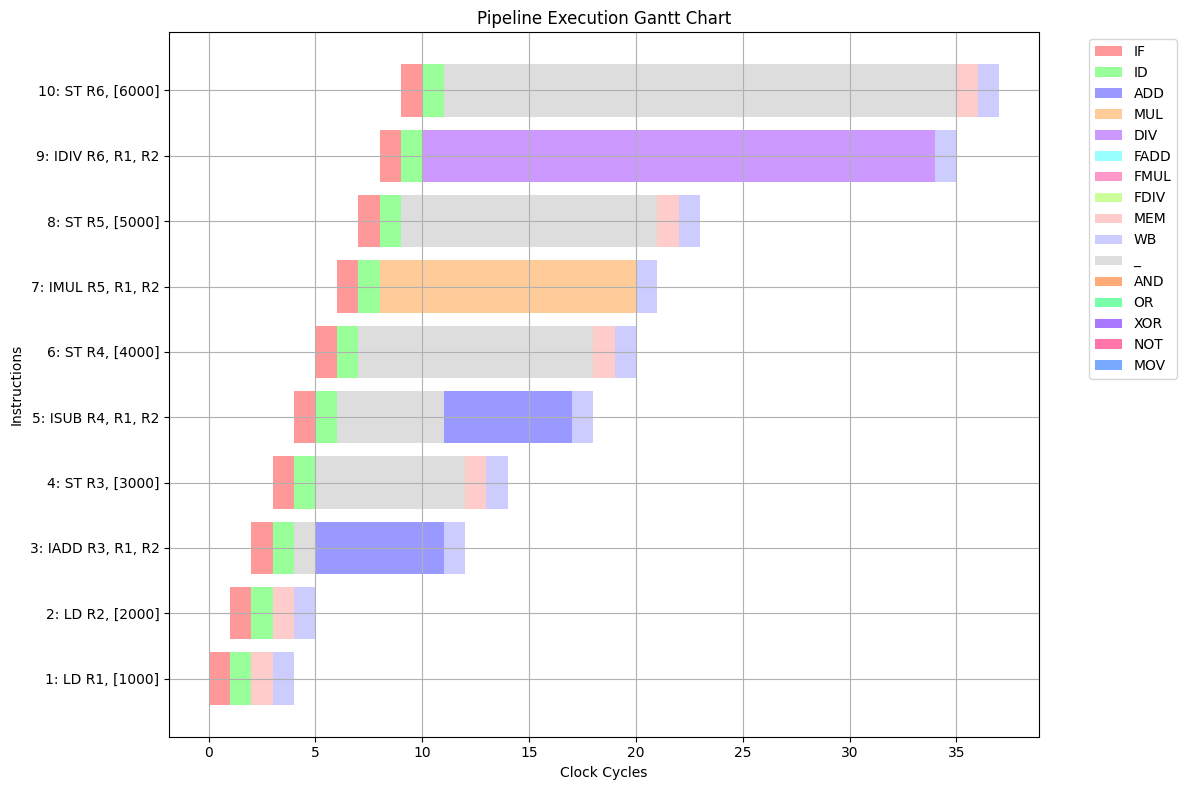

In [1]:
import re

# Define pipeline stages and latencies
pipeline_stages = {
    # integer
    'IADD': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1},
    'ISUB': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1},
    'IMUL': {'IF': 1, 'ID': 1, 'MUL': 12, 'WB': 1},
    'IDIV': {'IF': 1, 'ID': 1, 'DIV': 24, 'WB': 1},

    # floating
    'FADD': {'IF': 1, 'ID': 1, 'FADD': 18, 'WB': 1},
    'FSUB': {'IF': 1, 'ID': 1, 'FADD': 18, 'WB': 1},
    'FMUL': {'IF': 1, 'ID': 1, 'FMUL': 30, 'WB': 1},
    'FDIV': {'IF': 1, 'ID': 1, 'FDIV': 60, 'WB': 1},

    # logical operations
    'AND': {'IF': 1, 'ID': 1, 'AND': 1, 'WB': 1},
    'OR': {'IF': 1, 'ID': 1, 'OR': 1, 'WB': 1},
    'XOR': {'IF': 1, 'ID': 1, 'XOR': 1, 'WB': 1},
    'NOT': {'IF': 1, 'ID': 1, 'NOT': 1, 'WB': 1},

    # load and store
    'LD': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1},
    'ST': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1},

    # NOP
    'NOP': {'IF': 1},

    # move
    'MOV': {'IF': 1, 'ID': 1, 'MOV': 1, 'WB': 1}
}

# Define reservation station limits for each functional unit type
# rs_limits = {
#     'ADD': 4,     # Integer adder
#     'MUL': 3,     # Integer multiplier
#     'DIV': 2,     # Integer divider
#     'FADD': 4,    # Floating-point adder
#     'FMUL': 3,    # Floating-point multiplier
#     'FDIV': 2,    # Floating-point divider
#     'AND': 2,     # Logical AND
#     'OR': 2,      # Logical OR
#     'XOR': 2,     # Logical XOR
#     'NOT': 2,     # Logical NOT
#     'MEM': 4,     # Load/Store unit
#     'MOV': 2      # Move unit
# }

rs_limits = {
    'ADD': 2,     # Integer adder
    'MUL': 2,     # Integer multiplier
    'DIV': 2,     # Integer divider
    'FADD': 2,    # Floating-point adder
    'FMUL': 2,    # Floating-point multiplier
    'FDIV': 2,    # Floating-point divider
    'AND': 2,     # Logical AND
    'OR': 2,      # Logical OR
    'XOR': 2,     # Logical XOR
    'NOT': 2,     # Logical NOT
    'MEM': 2,     # Load/Store unit
    'MOV': 2      # Move unit
}

def get_functional_unit_and_latency(stages):
    functional_units = ['ADD', 'MUL', 'DIV', 'FADD', 'FMUL', 'FDIV', 'MEM']
    for stage, latency in stages.items():
        if stage in functional_units:
            return stage, latency
    return None, None  # No functional unit found

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_pipeline_gantt(instructions, total_cycles):
    # Define stage colors
    stage_colors = {
        'IF': '#FF9999',
        'ID': '#99FF99',
        'ADD': '#9999FF',
        'MUL': '#FFCC99',
        'DIV': '#CC99FF',
        'FADD': '#99FFFF',
        'FMUL': '#FF99CC',
        'FDIV': '#CCFF99',
        'MEM': '#FFCCCC',
        'WB': '#CCCCFF',
        '_': '#DDDDDD',  # Wait cycles
        'AND': '#FFAA77',
        'OR': '#77FFAA',
        'XOR': '#AA77FF',
        'NOT': '#FF77AA',
        'MOV': '#77AAFF'
    }

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set y-axis labels (instruction names)
    y_labels = []
    for i, instr in enumerate(instructions):
        if instr['op'] in ['LD', 'ST']:
            y_labels.append(f"{i+1}: {instr['op']} {instr['dest']}, [{instr['src1']}]")
        elif instr['op'] == 'NOP':
            y_labels.append(f"{i+1}: NOP")
        else:
            y_labels.append(f"{i+1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")

    # Initialize timeline for each instruction
    timeline = {}
    for i, instr in enumerate(instructions):
        timeline[i] = [''] * total_cycles
        current_cycle = i

        # Handle NOP instructions differently
        if instr['op'] == 'NOP':
            timeline[i][current_cycle] = 'IF'  # Only IF stage for NOP
            current_cycle += 1
        else:
            # Regular instructions: IF and ID first
            timeline[i][current_cycle] = 'IF'
            current_cycle += 1
            timeline[i][current_cycle] = 'ID'
            current_cycle += 1

        # Add wait cycles if any
        if 'wait_cycles' in instr:
            for cycle in range(current_cycle, current_cycle + instr['wait_cycles']):
                if cycle < total_cycles:
                    timeline[i][cycle] = '_'
            current_cycle += instr['wait_cycles']

        # Fill remaining stages (skip for NOP)
        if instr['op'] != 'NOP':
            for stage, latency in instr['stages'].items():
                if stage not in ['IF', 'ID']:  # Skip IF and ID since already handled
                    for cycle in range(current_cycle, current_cycle + latency):
                        if cycle < total_cycles:
                            timeline[i][cycle] = stage
                    current_cycle += latency

    # Plot each instruction's timeline
    for i, instr in enumerate(instructions):
        for cycle in range(total_cycles):
            stage = timeline[i][cycle]
            if stage:  # Only plot if there's a stage
                ax.broken_barh([(cycle, 1)], (i-0.4, 0.8),
                              facecolors=stage_colors.get(stage, '#FFFFFF'))

    # Customize the plot
    ax.set_yticks(range(len(instructions)))
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Clock Cycles')
    ax.set_ylabel('Instructions')
    ax.set_title('Pipeline Execution Gantt Chart')
    ax.grid(True)

    # Create legend
    legend_elements = [Patch(facecolor=color, label=stage)
                      for stage, color in stage_colors.items()]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

def display_clock_cycle_execution(updated_instructions, total_cycles):
    # Initialize a timeline for each instruction
    timeline = {}
    for i, instr in enumerate(updated_instructions):
        timeline[i] = [' '] * total_cycles  # Initialize with empty spaces for all clock cycles

    # Track the start cycle for each instruction
    for i, instr in enumerate(updated_instructions):
        stages = instr['stages']
        current_cycle = i  # Start at cycle i (0-based index)

        # Always display IF and ID first
        timeline[i][current_cycle] = 'IF'
        current_cycle += 1
        timeline[i][current_cycle] = 'ID'
        current_cycle += 1

        # Add wait cycles (`_`) if any
        if 'wait_cycles' in instr:
            for cycle in range(current_cycle, current_cycle + instr['wait_cycles']):
                if cycle < total_cycles:
                    timeline[i][cycle] = '_'
            current_cycle += instr['wait_cycles']

        # Fill the timeline for the remaining stages
        for stage, latency in stages.items():
            if stage not in ['IF', 'ID']:  # Skip IF and ID since they are already handled
                for cycle in range(current_cycle, current_cycle + latency):
                    if cycle < total_cycles:
                        timeline[i][cycle] = stage
                current_cycle += latency

    # Determine maximum stage name length for uniform spacing
    max_stage_length = max(len(stage) for instr in updated_instructions for stage in instr['stages'])
    max_cycle_length = len(str(total_cycles))  # Maximum length of clock cycle numbers

    # Define column width based on the maximum length
    column_width = max(max_stage_length, max_cycle_length) + 2  # Add padding

    # Determine the maximum instruction name length for dynamic spacing
    max_instr_length = max(
        len(f"{i + 1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")
        if instr['op'] not in ['LD', 'ST', 'NOP']
        else len(f"{i + 1}: {instr['op']} {instr['dest']}, [{instr['src1']}]")
        if instr['op'] in ['LD', 'ST']
        else len(f"{i + 1}: NOP")
        for i, instr in enumerate(updated_instructions)
    )

    # Print the timeline
    print("Clock Cycle Execution:")
    print(" " * (max_instr_length + 2) + "|", end="")
    for cycle in range(1, total_cycles + 1):
        print(f" {cycle:^{column_width}} |", end="")  # Center-align clock cycles
    print()

    for i, instr in enumerate(updated_instructions):
        # Display the instruction name with index
        if instr['op'] in ['LD', 'ST']:
            instruction_name = f"{i + 1}: {instr['op']} {instr['dest']}, [{instr['src1']}]"
        elif instr['op'] == 'NOP':
            instruction_name = f"{i + 1}: NOP"
        else:
            instruction_name = f"{i + 1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}"

        # Print the instruction name and its stages
        print(f"{instruction_name: <{max_instr_length}} |", end="")
        for cycle in range(total_cycles):
            stage = timeline[i][cycle]
            print(f" {stage:^{column_width}} |", end="")  # Center-align stages
        print()

def display_functional_units(updated_instructions, total_cycles):
    # Define the functional units
    functional_units = ['ADD', 'MUL', 'DIV', 'FADD', 'FMUL', 'FDIV', 'AND', 'OR', 'XOR', 'NOT', 'MEM']

    # Initialize a timeline for each functional unit
    timeline = {unit: [' '] * len(updated_instructions) for unit in functional_units}

    # Track the start cycle for each instruction
    for i, instr in enumerate(updated_instructions):
        stages = instr['stages']
        functional_unit, _ = get_functional_unit_and_latency(stages)
        # print("functional_unit : ", functional_unit)

        # Format the full instruction string
        if instr['op'] in ['LD', 'ST']:
            instruction_str = f"{instr['op']} {instr['dest']}, [{instr['src1']}]"
        elif instr['op'] == 'NOP':
            instruction_str = "NOP"
        else:
            instruction_str = f"{instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}"

        if functional_unit:
            # Place the instruction only in its corresponding functional unit
            timeline[functional_unit][i] = instruction_str
        else:
            # Handle NOP instructions (display in all functional units)
            for unit in functional_units:
                timeline[unit][i] = instruction_str

    # Determine the maximum instruction length for each functional unit
    max_instr_lengths = {unit: 0 for unit in functional_units}
    for unit in functional_units:
        for i in range(len(updated_instructions)):
            instruction = timeline[unit][i]
            if len(instruction) > max_instr_lengths[unit]:
                max_instr_lengths[unit] = len(instruction)

    # Adjust spacing based on the number of letters in the unit name
    for unit in functional_units:
        if len(unit) == 3:  # 3-letter units (DIV, AND, XOR, NOT, etc.)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], 10)  # More spacing
        elif len(unit) == 4:  # 4-letter units (FADD, FMUL, FDIV, etc.)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], 8)  # Less spacing
        else:  # Other units (e.g., MEM)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], len(unit))

    # Print the functional units horizontally at the top
    print("Functional Units Execution:")
    print(" " * len(str(len(updated_instructions))) + " |", end="")
    for unit in functional_units:
        print(f" {unit:^{max_instr_lengths[unit]}} |", end="")
    print()

    # Print the instruction number and the timeline
    for i in range(len(updated_instructions)):
        print(f"{i + 1:>{len(str(len(updated_instructions)))}} |", end="")
        for unit in functional_units:
            stage = timeline[unit][i]
            print(f" {stage:^{max_instr_lengths[unit]}} |", end="")
        print()

from collections import defaultdict, deque

def handle_reservation_stations(instructions, total_cycles):
    # Initialize available reservation stations
    available_rs = rs_limits.copy()

    # Create separate queues for each functional unit type
    rs_queues = defaultdict(deque)

    # Track when each instruction acquires and releases reservation stations
    rs_events = []

    for cycle in range(total_cycles):
        print(f"\nCycle {cycle + 1}:")

        # First, release reservation stations for instructions that are done
        for i, instr in enumerate(instructions):
            # Check if instruction has reached its RS release cycle
            if (i + 2 + instr.get('wait_cycles', 0)) == cycle:
                functional_unit = instr.get('functional_unit', None)
                if functional_unit and 'rs_acquired' in instr:
                    # Release the reservation station
                    available_rs[functional_unit] += 1
                    print(f"  Released RS for {functional_unit}. Now available: {available_rs[functional_unit]}/{rs_limits[functional_unit]}")

                    # Check if there are instructions waiting in this unit's queue
                    if rs_queues[functional_unit]:
                        # Pop the next instruction from the queue
                        queued_instr_idx = rs_queues[functional_unit].popleft()
                        queued_instr = instructions[queued_instr_idx]

                        # Acquire RS for the queued instruction
                        available_rs[functional_unit] -= 1
                        queued_instr['rs_acquired'] = True
                        queued_instr['rs_acquired_cycle'] = cycle
                        print(f"  Popped instruction {queued_instr_idx+1} from {functional_unit} queue")
                        print(f"  Instruction {queued_instr_idx+1} acquired {functional_unit} RS. Now available: {available_rs[functional_unit]}/{rs_limits[functional_unit]}")

        # Then, try to acquire reservation stations for instructions reaching RS stage
        for i, instr in enumerate(instructions):
            # Only check instructions that are at cycle i+2 (after IF and ID)
            if (i + 2) != cycle:
                continue

            if instr['op'] == 'NOP':
                continue  # NOP doesn't need reservation station

            functional_unit = instr.get('functional_unit', None)
            if not functional_unit:
                continue  # Skip if no functional unit (shouldn't happen)

            # Only need RS if instruction has wait cycles
            if 'wait_cycles' in instr and instr['wait_cycles'] > 0:
                if available_rs[functional_unit] > 0:
                    # Acquire the reservation station
                    available_rs[functional_unit] -= 1
                    instr['rs_acquired'] = True
                    instr['rs_acquired_cycle'] = cycle
                    print(f"  Instruction {i+1} acquired {functional_unit} RS. Now available: {available_rs[functional_unit]}/{rs_limits[functional_unit]}")
                else:
                    # Push to the appropriate queue
                    rs_queues[functional_unit].append(i)
                    print(f"  {functional_unit} RS full! Instruction {i+1} pushed to {functional_unit} queue")

    # Print final status
    print("\nFinal Reservation Station Status:")
    for unit, limit in rs_limits.items():
        print(f"{unit}: {available_rs[unit]}/{limit} available")

    print("\nFinal Queue Status:")
    for unit, queue in rs_queues.items():
        if queue:
            print(f"{unit} queue: [{' '.join(f'I{idx+1}' for idx in queue)}]")
        else:
            print(f"{unit} queue: empty")

# Function to handle structural and raw hazards
def handle_hazards(instructions):
    updated_instructions = []
    total_cycles = 0

    for i, instruction in enumerate(instructions):
        if i > 0:
            curr_instr = instructions[i]
            curr_func_unit, curr_func_latency = get_functional_unit_and_latency(curr_instr['stages'])

            curr_instr['functional_unit'] = curr_func_unit

            # Track wait cycles for structural and RAW hazards
            structural_wait = 0

            # Check for structural hazards (same functional unit)
            for j in range(i - 1, -1, -1):
                prev_instr = instructions[j]
                prev_func_unit, prev_func_latency = get_functional_unit_and_latency(prev_instr['stages'])

                # Structural hazard: Same functional unit
                if prev_func_unit is not None and curr_func_unit == prev_func_unit:
                    # Calculate the number of wait cycles needed
                    structural_wait = max(structural_wait, (j - i + sum(prev_instr['stages'].values()) - 3)) + prev_instr.get('wait_cycles', 0)  # 3 for IF, ID and WB
                    # wait_cycles = max(wait_cycles, structural_wait)
                    break  # Stop after finding the first conflict

            # Check for RAW hazards (data dependencies)
            raw_wait = 0
            curr_registers = []
            if 'src1' in curr_instr and curr_instr['src1'] is not None:
                curr_registers.append(curr_instr['src1'])
            if 'src2' in curr_instr and curr_instr['src2'] is not None:
                curr_registers.append(curr_instr['src2'])
            if 'dest' in curr_instr and curr_instr['dest'] is not None and curr_instr['op'] == 'ST':
                curr_registers.append(curr_instr['dest'])

            for j in range(i - 1, -1, -1):
                prev_instr = instructions[j]
                # Check if the previous instruction writes to a register used by the current instruction
                if 'dest' in prev_instr and prev_instr['dest'] is not None and prev_instr['op'] != 'ST':
                    prev_dest_register = prev_instr['dest']
                    if prev_dest_register in curr_registers:
                        # Calculate the number of wait cycles needed
                        raw_wait = max(raw_wait, (j + sum(prev_instr['stages'].values())) - (i + 2)) + prev_instr.get('wait_cycles', 0)  # 2 for IF and ID
                        # wait_cycles = max(wait_cycles, raw_wait)
                        break

            # Add wait cycles to the current instruction
            # if wait_cycles > 0:
            #     if 'wait_cycles' not in curr_instr:
            #         curr_instr['wait_cycles'] = 0
            #     curr_instr['wait_cycles'] += wait_cycles
            if structural_wait >= raw_wait:
                # if 'wait_cycles' not in curr_instr:
                #     curr_instr['wait_cycles'] = 0
                curr_instr['wait_cycles'] = structural_wait
                print("structural_wait : ", structural_wait)
            else:
                # if 'wait_cycles' not in curr_instr:
                #     curr_instr['wait_cycles'] = 0
                curr_instr['wait_cycles'] = raw_wait
                print("raw_wait : ", raw_wait)

        # Add the current instruction
        # updated_instructions.append(instruction)
        print(f"instruction : {instruction}, curr_instr['wait_cycles'] : {instruction.get('wait_cycles', 0)}")

        # Update total_cycles
        time = sum(instruction['stages'].values())
        total_cycles = max(i + time + instruction.get('wait_cycles', 0), total_cycles)

    return instructions, total_cycles

def handle_waw_and_war(updated_instructions, total_cycles):
    # Initialize a register counter to track availability
    register_counter = {f'R{i}': 0 for i in range(32)}  # R0 to R31
    # register_counter = {f'R{i}': 0 for i in range(2)}  # R0 to R1

    # Function to find the next available register
    def find_available_register():
        for reg, counter in register_counter.items():
            if counter == 0:
                return reg
        return None  # No available register (should not happen in normal cases)

    def find_available_register2(reg2):
        for reg, counter in register_counter.items():
            if counter == 0 and reg != reg2:
                return reg
        return None  # No available register (should not happen in normal cases)

    # Iterate through instructions to handle WAW and WAR
    i = 0
    while i < len(updated_instructions):
        curr_instr = updated_instructions[i]

        # # Skip NOP instructions
        # if curr_instr['op'] == 'NOP':
        #     i += 1
        #     continue

        # Get the destination register of the current instruction
        if 'dest' in curr_instr and curr_instr['op'] != 'ST':
          dest_reg = curr_instr['dest']
        else:
          dest_reg = None

        # Handle WAW (Write-After-Write) hazard
        if dest_reg is not None:
            new_dest_reg = None

            # Check if any previous instruction reads from the destination register
            for j in range(i - 1, -1, -1):
                prev_instr = updated_instructions[j]
                if ('dest' in prev_instr and prev_instr['dest'] == dest_reg and prev_instr['op'] != 'ST' and register_counter[dest_reg] != 0):
                    # Find a new available register
                    new_dest_reg = find_available_register()

                    k = i + 1
                    found = False
                    while k < len(updated_instructions):
                      subsequent_instr = updated_instructions[k]
                      if 'src1' in subsequent_instr and subsequent_instr['src1'] == new_dest_reg:
                          found = True
                          break
                      if 'src2' in subsequent_instr and subsequent_instr['src2'] == new_dest_reg:
                          found = True
                          break
                      if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == new_dest_reg:
                          found = True
                          break
                      k+=1

                    if found == True:
                      new_dest_reg = find_available_register2(new_dest_reg)

                    print("prev_instr : ", prev_instr)
                    print(f"{dest_reg} : {register_counter[dest_reg]}")
                    if new_dest_reg is None:
                        print("Error: No available registers.")
                        # return updated_instructions, total_cycles
                        return [], total_cycles

                        # # No available register, find the register with the smallest counter
                        # min_reg, min_counter = min(register_counter.items(), key=lambda x: x[1])  # Find register with smallest counter
                        # if min_reg is None:
                        #     print("Error: No registers available.")
                        #     return updated_instructions, total_cycles

                        # # Insert NOPs equal to the smallest counter value
                        # nops_needed = min_counter
                        # print("nops_needed : ", nops_needed)
                        # for _ in range(nops_needed):
                        #     updated_instructions.insert(i, {'op': 'NOP', 'stages': pipeline_stages['NOP']})
                        #     total_cycles += 1  # Increment total cycles

                        # # Reset the counter for the selected register
                        # register_counter[min_reg] = 0
                        # new_dest_reg = min_reg

                    # Update the destination register of the current instruction
                    print("curr_instr before : ", curr_instr)
                    curr_instr['dest'] = new_dest_reg
                    print("curr_instr after : ", curr_instr)
                    print("new_dest_reg : ", new_dest_reg)

                    if new_dest_reg is not None:
                        break

            if new_dest_reg is not None:
                k = i + 1
                # Update subsequent instructions that use the old destination register
                # for k in range(i + 1, len(updated_instructions)):
                while k < len(updated_instructions):
                    subsequent_instr = updated_instructions[k]
                    if 'src1' in subsequent_instr and subsequent_instr['src1'] == dest_reg:
                        subsequent_instr['src1'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'src2' in subsequent_instr and subsequent_instr['src2'] == dest_reg:
                        subsequent_instr['src2'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == dest_reg:
                        subsequent_instr['dest'] = new_dest_reg
                        print("subsequent_instr : ", subsequent_instr)
                    if 'dest' in subsequent_instr and subsequent_instr['op'] != 'ST' and subsequent_instr['dest'] == dest_reg:
                        break
                    k+=1


            # Update the register counter for the new destination register
            if new_dest_reg is not None:
              register_counter[new_dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages

        # # Handle WAR (Write-After-Read) hazard
        # if dest_reg is not None:
        #     # Check if any previous instruction reads from the destination register
        #     for j in range(i - 1, -1, -1):
        #         prev_instr = updated_instructions[j]
        #         if ('src1' in prev_instr and prev_instr['src1'] == dest_reg) or \
        #         ('src2' in prev_instr and prev_instr['src2'] == dest_reg) or \
        #         ('dest' in prev_instr and prev_instr['op'] == 'ST' and prev_instr['dest'] == dest_reg):
        #             # Find a new available register
        #             new_dest_reg = find_available_register()
        #             if new_dest_reg is None:
        #                 print("Error: No available registers.")
        #                 return updated_instructions, total_cycles

        #             # Update the destination register of the current instruction
        #             curr_instr['dest'] = new_dest_reg

        #             # Update subsequent instructions that use the old destination register
        #             for k in range(i + 1, len(updated_instructions)):
        #                 subsequent_instr = updated_instructions[k]
        #                 if 'src1' in subsequent_instr and subsequent_instr['src1'] == dest_reg:
        #                     subsequent_instr['src1'] = new_dest_reg
        #                 if 'src2' in subsequent_instr and subsequent_instr['src2'] == dest_reg:
        #                     subsequent_instr['src2'] = new_dest_reg
        #                 if 'dest' in subsequent_instr and subsequent_instr['op'] == 'ST' and subsequent_instr['dest'] == dest_reg:
        #                     subsequent_instr['dest'] = new_dest_reg

        #             # Update the register counter for the new destination register
        #             register_counter[new_dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages
        #             break

        # # Update the register counter for the destination register
        # if dest_reg is not None:
        #     register_counter[dest_reg] = sum(curr_instr['stages'].values()) - 2  # Exclude IF and ID stages


        # if 'src1' in curr_instr and curr_instr['src1'] is not None and \
        # curr_instr['src1'] in {'R{i}': 0 for i in range(32)} and register_counter[curr_instr['src1']] == 0:
        #   register_counter[curr_instr['src1']] = sum(curr_instr['stages'].values()) - 2
        # if 'src2' in curr_instr and curr_instr['src2'] is not None and register_counter[curr_instr['src2']] == 0:
        #   register_counter[curr_instr['src2']] = sum(curr_instr['stages'].values()) - 2
        if 'dest' in curr_instr and curr_instr['dest'] is not None and \
         curr_instr['op'] != 'ST' and register_counter[curr_instr['dest']] == 0:
          register_counter[curr_instr['dest']] = sum(curr_instr['stages'].values()) - 2

        # Decrement the counter for all registers at each clock cycle
        for reg in register_counter:
            print(f"{reg} : {register_counter[reg]}")
            if register_counter[reg] > 0:
                register_counter[reg] -= 1

        i += 1

    return updated_instructions, total_cycles

# Function to parse assembly code
import re

def parse_assembly(assembly):
    instructions = []
    valid_ops = ['IADD', 'ISUB', 'IMUL', 'IDIV', 'FADD', 'FSUB', 'FMUL', 'FDIV', 'AND', 'OR', 'XOR', 'NOT', 'LD', 'ST', 'MOV', 'NOP']

    for line in assembly:
        line = line.strip()

        # Skip empty lines
        if not line:
            continue

        # Regex for arithmetic/logic instructions (e.g., IADD R1, R2, R3)
        match_arithmetic = re.match(r'^(IADD|ISUB|IMUL|IDIV|FADD|FSUB|FMUL|FDIV|AND|OR|XOR|NOT)\s+(R\d+),\s*(R\d+),\s*(R\d+)$', line)

        # Regex for MOV instructions (e.g., MOV R8, R7 or MOV R8, 1000)
        match_mov = re.match(r'^(MOV)\s+(R\d+),\s*(R\d+|\d+)$', line)

        # Regex for memory instructions with register or immediate address (e.g., LD R8, [R9] or LD R8, [1000])
        match_memory = re.match(r'^(LD|ST)\s+(R\d+),\s*\[(R\d+|\d+)\]$', line)

        # Regex for NOP instruction
        match_nop = re.match(r'^NOP$', line)

        # Check if the operation is valid
        op = line.split()[0] if line else None
        if op not in valid_ops:
            print(f"Error: Unknown instruction `{op}`.")
            return []

        if match_arithmetic:
            op = match_arithmetic.group(1)
            dest = match_arithmetic.group(2)
            src1 = match_arithmetic.group(3)
            src2 = match_arithmetic.group(4)

            # Check if registers are valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []
            if not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []
            if not (0 <= int(src2[1:]) <= 31):
                print(f"Error: Invalid register name `{src2}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': src2, 'stages': pipeline_stages[op]})

        elif match_mov:
            op = match_mov.group(1)
            dest = match_mov.group(2)
            src1 = match_mov.group(3)

            # Check if destination register is valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []

            # Check if source is a register and valid (R0 to R31)
            if src1.startswith('R') and not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': None, 'stages': pipeline_stages[op]})

        elif match_memory:
            op = match_memory.group(1)
            dest = match_memory.group(2)
            src1 = match_memory.group(3)

            # Check if destination register is valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []

            # Check if source is a register and valid (R0 to R31)
            if src1.startswith('R') and not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': None, 'stages': pipeline_stages[op]})

        elif match_nop:
            instructions.append({'op': 'NOP', 'dest': None, 'src1': None, 'src2': None, 'stages': pipeline_stages['NOP']})

        else:
            # If the line doesn't match any regex, it's an unknown instruction
            print(f"Error: Unknown instruction `{line.split()[0]}`.")
            return []

    return instructions

# Main function
def main():
    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FMUL R14, R15, R16"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16",
    #     "FADD R17, R18, R19"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "FDIV R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16",
    #     "FADD R17, R18, R19"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "IADD R7, R8, R9"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "IADD R7, R8, R9",
    #     "IADD R10, R11, R12"
    # ]

    # assembly_code = [
    #     "LD R7, [1000]",
    #     "IADD R1, R2, R3",
    #     "FMUL R4, R5, R6",
    #     "IADD R7, R8, R9",
    #     "IADD R10, R11, R12"
    # ]

    # assembly_code = [
    #     "LD R2, [1000]",
    #     "LD R3, [2000]",
    #     "IADD R1, R2, R3",
    #     "LD R2, [3000]",
    #     "IADD R4, R1, R2",
    #     "IADD R4, R4, R1",
    #     "IADD R4, R5, R6"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R1, R2"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R4, R2"
    # ]

    # assembly_code = [
    #     "IDIV R3, R1, R3",
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R4, R3"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IDIV R3, R1, R3",
    #     "ISUB R1, R4, R3"
    # ]

    # assembly_code = [
    #     "IDIV R3, R1, R3",
    #     "IMUL R1, R2, R4",
    #     "ISUB R6, R4, R5"
    # ]

    # assembly_code = [
    #     "LD R2, [1000]",
    #     "LD R3, [2000]",
    #     "IADD R1, R2, R3",
    #     "LD R2, [3000]",
    #     "IADD R4, R1, R2",
    #     "IADD R4, R4, R1",
    #     "IADD R4, R5, R6",
    #     "ST R4, [3000]",
    #     "ST R4, [4000]",
    #     "IADD R4, R5, R7",
    #     "ST R4, [5000]"
    # ]

    # assembly_code = [
    #     "LD R0, [1000]",
    #     "LD R1, [2000]",
    #     "IADD R1, R1, R0",
    #     "IMUL R1, R0, R0",
    #     "IADD R1, R0, R0"
    # ]

    # assembly_code = [
    #     "LD R0, [1000]",
    #     "LD R1, [2000]",
    #     "IADD R1, R1, R0",
    #     "IMUL R1, R0, R0",
    #     "IDIV R1, R0, R0"
    # ]

    # # calculator program
    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R3, R1, R2",
    #     "ST R3, [3000]",
    #     "ISUB R3, R1, R2",
    #     "ST R3, [4000]",
    #     "IMUL R3, R1, R2",
    #     "ST R3, [5000]",
    #     "IDIV R3, R1, R2",
    #     "ST R3, [6000]"
    # ]

    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R3, R1, R2",
    #     "ISUB R4, R1, R2",
    #     "IADD R4, R4, R2",
    #     "IMUL R5, R1, R2",
    #     "IDIV R6, R1, R2",
    #     "ST R3, [3000]",
    #     "ST R4, [4000]",
    #     "ST R5, [5000]",
    #     "ST R6, [6000]"
    # ]

    assembly_code = [
        "LD R1, [1000]",
        "LD R2, [2000]",
        "IADD R3, R1, R2",
        "ST R3, [3000]",
        "ISUB R4, R1, R2",
        "ST R4, [4000]",
        "IMUL R5, R1, R2",
        "ST R5, [5000]",
        "IDIV R6, R1, R2",
        "ST R6, [6000]"
    ]

    # # calculator program
    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R3, R1, R2",
    #     "ISUB R4, R1, R2",
    #     "IMUL R5, R1, R2",
    #     "IDIV R6, R1, R2",
    #     "ST R3, [3000]",
    #     "ST R4, [4000]",
    #     "ST R5, [5000]",
    #     "ST R6, [6000]"
    # ]

    instructions = parse_assembly(assembly_code)
    if not instructions:
        return
    # updated_instructions, total_cycles = insert_nops_for_structural_hazards(instructions)
    # updated_instructions, total_cycles = handle_raw_dependencies(updated_instructions, total_cycles)
    # updated_instructions, total_cycles = handle_waw_and_war(updated_instructions, total_cycles)

    # total_cycles = 0
    # updated_instructions, total_cycles = insert_nops_for_structural_hazards(instructions)
    # # updated_instructions, total_cycles = handle_raw_dependencies(updated_instructions, total_cycles)
    # updated_instructions, total_cycles = handle_waw_and_war(updated_instructions, total_cycles)


    updated_instructions, total_cycles = handle_hazards(instructions)
    updated_instructions, total_cycles = handle_waw_and_war(updated_instructions, total_cycles)

    if not updated_instructions:
        print("Register Spill")
        return

    print("Updated Code with NOPs and Register Updates:")
    for instr in updated_instructions:
        if instr['op'] == 'NOP':
            print("NOP")
        else:
            if instr['op'] in ['LD', 'ST']:
                print(f"{instr['op']} {instr['dest']}, [{instr['src1']}]")
            else:
                print(f"{instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")

    print(f"\nTotal clock cycles: {total_cycles}")


    # for i, instr in enumerate(updated_instructions):
    #     if instr['op'] in ['LD', 'ST']:
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']} {instr['dest']}, [{instr['src1']}]")
    #     elif instr['op'] == 'NOP':
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']}")
    #     else:
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")
    print(" ")
    print(" ")
    display_functional_units(updated_instructions, total_cycles)
    print(" ")
    print(" ")
    display_clock_cycle_execution(updated_instructions, total_cycles)
    # print(" ")
    # print(" ")
    # plot_pipeline_gantt(updated_instructions, total_cycles)

    handle_reservation_stations(updated_instructions, total_cycles)
    print(" ")
    print(" ")
    plot_pipeline_gantt(updated_instructions, total_cycles)

if __name__ == "__main__":
    main()